# Combatting Partisan Homogenization in New Content Recommenders - Baselines

# Recent Updates:
Various Bugs were found, and i used stricter filtering conditions for the cluster pairs identification
* Fixed miscalculation of F1 scores due to wrong indexing in the Online Learning Setting Baseline
* Also the recall and precision were not macro, but f1 was so corrected all to macro
* Updated Graphs to be saved in pdf for easier upload into overleaf latex doc
* Added Stricter Criteria for Cluster Pair Filtering
    * Min partisan size (From 0.3 -> 0.4)
    * Min cluster size (From 300 -> 500)
* Partial fit only occurs if user likes the article recommended
* Removed Zero division for precision and recall 
* Implemented scoring @ K

# Main Components
1) Data Loading  
2) Sampling  
3) Text Preprocessing  
4) Vectorization  
5) Dimensionality Reductions  
6) Clustering  
7) Clustering Performance Check  
8) Cluster Filtering  
9) Pairwise Selection  
10) Model Training and Performance  
11) Pairwise score analysis


### Part 1 : Topic Clustering and Recommender Performance for Homogeneous and Heterogeneous Users
This is a classic setting, where we first identify different topics in the corpus using clustering then identify similar clusters and rank them by their similarity to perform a pairwise analysis of cluster similarity vs model performance metrics. 
* This can help identify how hard the problem is when topics are very similar to each other vs when they differ greatly in similarity
* Results:

### Part 2: Online Learning Setting (To simulate real world settings)
This is an online learning setting to simulate a real world recommendation system setting, to see how incoming user interactions affect the model performance  for both heterogeneous and homogenous users.
* For this setting we measure the performance metrics in 2 ways:
    * Active Learning Setting (Using a hold-out validation set)
    * Information Retrieval Setting (metrics @k calculations)
* Results:  

1) Model Performance Analysis :  
    * Check the F1 score calculation here , something is definetlyy wierd  --> DONE  
    * Calculate metrics@K  --> DONE

### Part 3: How Hard is Topic Detection
We compare the model performance of the online learning setting vs the intra-cluster setting (where we split our cluster 2 into train and validation).
We want to see which is easier for the model. The online learning task needs to be harder for this.
* Results:  

### Part 4: Limiting Spurrious Correlations
We want to limit the effect of spurrious correlations in the model(eg: words that jump stances across different topics) by varying the regularization parameter.
* Results:  

1) Vary Regularization Parameters to down-weight spurious correlations  
2) Limiting the effect of different semantic use of words across topics  
    * Eg: Topic 1: Some word w might indicate a more conservative stance  
    * Topic 2: The same word w might indicate a liberal stance  

#### Important:
* Heterogenous User:
    * Conservative on Cluster 1 but Liberal on Cluster 2
* Homogeneous User:
    * Conservative on Cluster 1 and Cluster 2

In [1]:
import os
from collections import Counter,defaultdict
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import pickle
import re
import seaborn as sns
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn import metrics
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV,SGDClassifier,PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
import joblib
from joblib import Parallel, delayed
from functools import wraps
from time import time
import itertools
from functools import partial
import functools
import time
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['axes.grid'] = True

In [4]:
np.random.seed(24101990)
RANDOM_SEED = np.random.randint(low=1, high=100000, size=1)[0]
print("Random_Seed Chosen : %s" %str(RANDOM_SEED))

Random_Seed Chosen : 15112


In [79]:
def timer(func):
    """
    Decorator to time a given function

    Parameters
    ----------
    func : generic
        The function to time

    Raises
    ------
    No Exceptions

    Returns
    -------
    value : generic
        The return value from func

    """
    @functools.wraps(func)
    def wrapper_timer(*args,**kwargs):
        start = time.perf_counter()
        value = func(*args,**kwargs)
        stop = time.perf_counter()
        run_time = stop - start
        print(f"\nFinished running {func.__name__!r} in {run_time/60.0:.4f} mins\n")
        return value
    return wrapper_timer

@timer
def preprocess_texts(text_lists):
    """
    """
    
    def select_first10(x):
        return " ".join(sent_tokenize(x)[:10])
    
    def to_lower(x):
        return x.lower()
    
    def remove_punc(x):
        return re.sub(r'[^\w\s]', '  ', x)
    
    def remove_small_words(x):
        return re.sub(r'\b\w{1,2}\b', '', x)
    
    def remove_spaces(x):
        return re.sub(' +', ' ', x)
    
    preprocess_pipe = [select_first10,to_lower,remove_punc,remove_small_words,remove_spaces]
    
    processed_texts = text_lists
    for preprocess_func in preprocess_pipe:
        print("Running : %s" %str(preprocess_func.__name__))
        processed_texts = Parallel(n_jobs=-1)(delayed(preprocess_func)(x) for x in processed_texts)

    return processed_texts

@timer
def load_data(path):
    """
    """
    df = pd.read_csv(path)
    print(df.columns)
    print("Df original shape : %s" %str(df.shape))
    # drop rows with text as nan
    df = df[df['text'].notna()]
    print("Df shape after dropping nan text : %s" %str(df.shape))
    # drop articles that have stance = 0
    df = df[df["source_partisan_score"] != 0]
    print("Df shape after dropping 0 stance articles : %s" %str(df.shape))
    # convert articles of stance -1,+1,-2,+2
    df["binary_ps"] = df["source_partisan_score"].apply(lambda x: 1 if x>=1 else 0)
    
    return df

@timer
def sample_data(df,sample_size=0.2,seed=RANDOM_SEED):
    """
    """
    return df.sample(frac=sample_size, replace=False, random_state=seed)

@timer
def vectorization(df,min_df=30,max_df=0.75,seed=RANDOM_SEED):
    """
    """
    df["all_text"] = df["title"] + " " + df["processed_text"]
    tfidf_vectorizer = TfidfVectorizer(min_df=min_df, binary=False, max_df=max_df, stop_words='english')
    vectors = tfidf_vectorizer.fit_transform(df["all_text"])
    vocab = tfidf_vectorizer.vocabulary_
    print("vocab_size : %s"%str(len(vocab)))
    return vectors,vocab,tfidf_vectorizer

@timer
def dimensionality_reduction(vectors,mode="PCA",dim=500,seed=RANDOM_SEED):
    """
    """
    print("\nShape Before DIM REDUC : %s" %str(vectors.shape))
    if mode == "PCA":
        pca = PCA(n_components=dim,svd_solver="arpack",random_state=seed)
        vectors = pca.fit_transform(vectors.todense())
        print("Shape After DIM REDUC : %s" %str(vectors.shape))
        return vectors
    if mode == "SVD_LSA":
        tsvd = TruncatedSVD(n_components=dim,algorithm="arpack",random_state=seed)
        vectors = tsvd.fit_transform(vectors)
        print("Shape After DIM REDUC : %s" %str(vectors.shape))
        return vectors
    
    if mode == "UMAP":
        return None

@timer
def run_clustering(vectors,seed=RANDOM_SEED,num_clusters=1000,clus_type="kmeans"):
    """
    """
    if clus_type == "kmeans":
        print("\nRunning KMEANS Clustering with k=%s" %str(num_clusters))
        km = MiniBatchKMeans(n_clusters=num_clusters, random_state=seed, n_init=3, max_iter=200, batch_size=1000)
        clusters = km.fit_predict(vectors)
        return clusters,km
    
    if clus_type == "spectral":
        return None
    
    if clus_type == "dbscan":
        return None

@timer
def get_cluster_sizes(cluster_clf):
    """
    """
    cluster_sizes = Counter(cluster_clf.labels_)
    return cluster_sizes

@timer
def score_cluster(vectors,cluster_clf,score_type="sil_score"):
    """
    """
    if score_type == "sil_score":
        sil_score = metrics.silhouette_score(vectors, cluster_clf.labels_, metric='euclidean')
        print("\nSilhouetter Score : %s" %str(sil_score))
        return sil_score
    
    return None

@timer
def get_cluster_pairs(num_clusters):
    """
    """
    cluster_pairs = list(itertools.combinations(range(num_clusters), 2))
    print("\nNumber of Cluster Pairs : %s" %str(len(cluster_pairs)))
    return cluster_pairs

@timer
def get_pairwise_dist(cluster_clf,dist_type="cosine"):
    """
    """
    pairwise_dist = None
    if dist_type == "cosine":
        pairwise_dist = cosine_similarity(cluster_clf.cluster_centers_)
    return pairwise_dist

@timer
def cluster2doc(num_texts,cluster_labels):
    """
    """
    cluster_2_doc = defaultdict(list)
    for index in range(num_texts):
        cluster = cluster_labels[index]
        cluster_2_doc[cluster].append(index)
    return cluster_2_doc


@timer
def filter_clusters(cluster_pairs,
                    doc_2_cluster_map,
                    cluster_sizes,
                    partisan_scores,
                    min_size=300,
                    max_size=5000,
                    min_partisan_size=0.3):
    """
    min_partisan_size : percentage of docs in the cluster that must have partisan score of 0 (and similarly 1), this removes pure clusters as well
    """

    def get_cluster_partisan_map(doc_2_cluster_map,partisan_scores):
        """
        """
        cluster_partisan_map = defaultdict(int)
        for cluster in doc_2_cluster_map:
            ps_scores = []
            for doc_id in doc_2_cluster_map[cluster]:
                ps_scores.append(partisan_scores[doc_id])
            cluster_partisan_map[cluster]=ps_scores
        
        return cluster_partisan_map
    
    cluster_partisan_map = get_cluster_partisan_map(doc_2_cluster_map,partisan_scores)
    
    def filter_min_max(cluster_pair,cluster_sizes):
        """
        Boolean Func
        """
        verdict = True
        cond1 = cluster_sizes[cluster_pair[0]] >= min_size and cluster_sizes[cluster_pair[0]] <= max_size 
        cond2 = cluster_sizes[cluster_pair[1]] >= min_size and cluster_sizes[cluster_pair[1]] <= max_size 
        if cond1 == True and cond2 == True:
            verdict = False
        
        return verdict
    
    partial_filter_min_max = partial(filter_min_max,cluster_sizes=cluster_sizes)
    
    def filter_partisan_size(cluster_pair,min_partisan_size,cluster_sizes,cluster_partisan_map):
        """
        Boolean Func
        takes a cluster pair and checks the partisan distribution compaired to its cluster size
        
        """
        conds = [True,True]
        for i,c in enumerate(cluster_pair):
            cluster_partisan = cluster_partisan_map[c]
            partisan_size = Counter(cluster_partisan)
            if partisan_size[0] >= int(cluster_sizes[c]*min_partisan_size) and partisan_size[1] >= int(cluster_sizes[c]*min_partisan_size):
                conds[i] = False
        
        if conds[0] == conds[1] == False:
            return False
        else:
            return True

    
    partial_filter_partisan_size = partial(filter_partisan_size,min_partisan_size=min_partisan_size,
                                                                cluster_sizes=cluster_sizes,
                                                                cluster_partisan_map=cluster_partisan_map)
    
    filter_verdicts_min_max = Parallel(n_jobs=-1)(delayed(partial_filter_min_max)(c_p) for c_p in cluster_pairs)
    filter_verdicts_partisan_size = Parallel(n_jobs=-1)(delayed(partial_filter_partisan_size)(c_p) for c_p in cluster_pairs)
    
    filtered_cps = []
    for index,cp in enumerate(cluster_pairs):
        if not filter_verdicts_min_max[index] and not filter_verdicts_partisan_size[index]:
            filtered_cps.append(cp)
    
    return filtered_cps

@timer
def get_top_100_clusterpairs(cluster_pairs,dist_matrix,reverse=True):
    """
    """
    sorted_cps = sorted(cluster_pairs,key=lambda x: dist_matrix[x[0],x[1]],reverse=reverse)[:100]
    return sorted_cps
    

@timer
def create_train_test(cluster_pair,cluster2doc,X_feats,df,user_type="Heterogeneous"):
    """
    Labels are based on conservative when homogenous, or conservative on cluster 1 and liberal on cluster 2 if heterogeneous
    """
    c1 = cluster_pair[0]
    c2 = cluster_pair[1]
    
    x_train = X_feats[cluster2doc[c1]]
    x_test = X_feats[cluster2doc[c2]]
    
    ps_train = df["binary_ps"].values[cluster2doc[c1]]
    ps_test = df["binary_ps"].values[cluster2doc[c2]]
    
    if user_type == "Heterogeneous":
        y_train = ps_train
        y_test = list(map(lambda x: 0.0 if x==1.0 else 1.0,ps_test))
    
    if user_type == "Homogeneous":
        y_train = ps_train
        y_test = ps_test
    
    u_train,c_train = np.unique(y_train, return_counts=True)
    u_test,c_test = np.unique(y_test, return_counts=True)
    print("Train Label Dist :\n %s : %s\n %s:%s" %(str(u_train[0]),str(c_train[0]),str(u_train[1]),str(c_train[1])))
    print("Test Label Dist :\n %s : %s\n %s:%s" %(str(u_test[0]),str(c_test[0]),str(u_test[1]),str(c_test[1])))
    
    assert x_train.shape[0] == len(y_train)
    assert x_test.shape[0] == len(y_test)
    
    return x_train,x_test,y_train,y_test


def get_scores(y_test,predictions,threshold,using_thresh=True):
    """
    """
    if using_thresh:
        predicted_probas = predictions[:,1]
        predictions = np.where(predicted_probas>=threshold,1,0).flatten()
    f1 = metrics.f1_score(y_test,predictions,zero_division=0,average="macro")
    precision = metrics.precision_score(y_test,predictions,zero_division=0,average="macro")
    recall = metrics.recall_score(y_test,predictions,zero_division=0,average="macro")
    accuracy = metrics.accuracy_score(y_test,predictions)
    
    return f1,precision,recall,accuracy

def get_scores_wot(y_test,predictions):
    """
    """
    f1 = metrics.f1_score(y_test,predictions,zero_division=0,average="macro")
    precision = metrics.precision_score(y_test,predictions,average="macro")
    recall = metrics.recall_score(y_test,predictions,average="macro")
    accuracy = metrics.accuracy_score(y_test,predictions)
    
    return f1,precision,recall,accuracy
    

@timer
def run_model(x_train,x_test,y_train,y_test,seed=RANDOM_SEED):
    """
    """
    clf = LogisticRegressionCV(cv=5,random_state=seed,max_iter=1000,n_jobs=-1,class_weight="balanced").fit(x_train, y_train)
    predicted_probas = clf.predict_proba(x_test)
    print(predicted_probas.shape)
    return clf,predicted_probas


def plot_size_dist(cluster_sizes):
    """
    """
    plt.figure(figsize=(20,10))
    plt.bar(cluster_sizes.keys(), cluster_sizes.values(),width=2)
    plt.xlabel("Cluster-Number")
    plt.ylabel("Documents in Cluster")
    plt.title("Cluster Size Distribution")
    plt.savefig("Graphs/cluster_size_dist.pdf")
    plt.show()
    
    

@timer
def plot_sim_vs_score(df_results,threshold):
    """
    """
    fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(15,15))
    axes = ax.ravel()
    sim_score = df_results["Cosine Distance"].tolist()
    scores = df_results["threshold - %s"%str(threshold)].tolist()
    f1,precision,recall,accuracy = zip(*scores)
    
    s = 50
    
    axes[0].scatter(sim_score,f1,marker="*",s=s)
    z = np.polyfit(sim_score,f1, 1)
    p = np.poly1d(z)
    axes[0].plot(sim_score,p(sim_score),"r--")
    axes[0].set_xlabel("Cosine Similarity between cluster pairs")
    axes[0].set_ylabel("F1-Score")
    
    axes[1].scatter(sim_score,precision,marker="o",s=s)
    z = np.polyfit(sim_score,precision, 1)
    p = np.poly1d(z)
    axes[1].plot(sim_score,p(sim_score),"r--")
    axes[1].set_xlabel("Cosine Similarity between cluster pairs")
    axes[1].set_ylabel("Precision")
    
    axes[2].scatter(sim_score,recall,marker="^",s=s)
    z = np.polyfit(sim_score,recall, 1)
    p = np.poly1d(z)
    axes[2].plot(sim_score,p(sim_score),"r--")
    axes[2].set_xlabel("Cosine Similarity between cluster pairs")
    axes[2].set_ylabel("Recall")
    
    axes[3].scatter(sim_score,accuracy,marker="+",s=s)
    z = np.polyfit(sim_score,accuracy, 1)
    p = np.poly1d(z)
    axes[3].plot(sim_score,p(sim_score),"r--")
    axes[3].set_xlabel("Cosine Similarity between cluster pairs")
    axes[3].set_ylabel("Accuracy")
    
    fig.suptitle("Cluster Similarity vs Classifier Performance | Threshold : %s" %str(threshold))
    fig.tight_layout()
    fig.savefig("Graphs/cluster_sim_vs_model_perf.pdf")
    plt.show()

def plot_helper(x1,x2,y1,y2,ax,ax_index,marker="*",s=50):
    """
    """
    ax[ax_index].scatter(x1,y1,marker=marker,color="tab:blue",s=s,label="Heterogeneous User")
    ax[ax_index].scatter(x2,y2,marker=marker,color="tab:red",s=s,label="Homogeneous User")
    
    sns.regplot(x=np.array(x1), y=np.array(y1),ax=ax[ax_index],color="cornflowerblue")
    sns.regplot(x=np.array(x2), y=np.array(y2),ax=ax[ax_index],color="lightcoral")
    
    ax[ax_index].legend(loc="upper right")
    
    
@timer
def plot_sim_vs_score_all_users(df_results_hetero,df_results_homo,threshold):
    """
    """
    fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(15,15))
    axes = ax.ravel()
    
    sim_score_hetero = df_results_hetero["Cosine Distance"].tolist()
    scores_hetero = df_results_hetero["threshold - %s"%str(threshold)].tolist()
    f1_hetero,precision_hetero,recall_hetero,accuracy_hetero = zip(*scores_hetero)
    
    sim_score_homo = df_results_homo["Cosine Distance"].tolist()
    scores_homo = df_results_homo["threshold - %s"%str(threshold)].tolist()
    f1_homo,precision_homo,recall_homo,accuracy_homo = zip(*scores_homo)
    
    s = 50
    
    plot_helper(x1=sim_score_hetero,
                x2=sim_score_homo,
                y1=f1_hetero,
                y2=f1_homo,
                ax=axes,
                ax_index=0,
                marker="*",
                s=50)
    axes[0].set_xlabel("Cosine Similarity between cluster pairs")
    axes[0].set_ylabel("F1-Score")
    
    plot_helper(x1=sim_score_hetero,
            x2=sim_score_homo,
            y1=precision_hetero,
            y2=precision_homo,
            ax=axes,
            ax_index=1,
            marker="o",
            s=50)
    axes[1].set_xlabel("Cosine Similarity between cluster pairs")
    axes[1].set_ylabel("Precision")

    plot_helper(x1=sim_score_hetero,
                x2=sim_score_homo,
                y1=recall_hetero,
                y2=recall_homo,
                ax=axes,
                ax_index=2,
                marker="^",
                s=50)
    axes[2].set_xlabel("Cosine Similarity between cluster pairs")
    axes[2].set_ylabel("Recall")

    plot_helper(x1=sim_score_hetero,
                x2=sim_score_homo,
                y1=accuracy_hetero,
                y2=accuracy_homo,
                ax=axes,
                ax_index=3,
                marker="+",
                s=50)
    axes[3].set_xlabel("Cosine Similarity between cluster pairs")
    axes[3].set_ylabel("Accuracy")
    
    
    
    fig.suptitle("Cluster Similarity vs Classifier Performance | Threshold : %s" %str(threshold))
    fig.tight_layout()
    fig.savefig("Graphs/cluster_sim_vs_model_perf_%s.pdf"%str(int(threshold*10)))
    plt.show()
    
@timer
def run_train_all(X,cluster_2_doc_map,df,cluster_pairs,cosine_mat,thresholds = [0.5,0.7,0.9],user_type="Heterogeneous"):
    """
    """
    results = defaultdict(list)
    for index,cp in enumerate(cluster_pairs):
            print("Training model for cluster pair : %s" %str(index))
            x_train,x_test,y_train,y_test = create_train_test(cluster_pair=cp,
                                                              cluster2doc=cluster_2_doc_map,
                                                              X_feats=X,
                                                              df=df,
                                                              user_type=user_type)

            clf,predicted_probas = run_model(x_train,x_test,y_train,y_test)

            for t in thresholds:
                f1,precision,recall,accuracy = get_scores(y_test,
                                                          predictions=predicted_probas,
                                                          threshold=t)
                results[t].append((f1,precision,recall,accuracy))
    
    
    
    df_results = pd.DataFrame(cluster_pairs,columns=["Cluster1","Cluster2"])
    sim_score = [cosine_mat[cp[0],cp[1]] for cp in cluster_pairs]
    df_results["Cosine Distance"] = sim_score
    for k in results:
        df_results["threshold - %s"%str(k)] = results[k]
    
    return df_results

@timer
def run_online_setting_active(X,cluster_2_doc_map,df,cluster_pairs,cosine_mat,user_type="Heterogeneous"):
    """
    """
    cp_scores_map = {}
    
    for index,cp in enumerate(cluster_pairs):
        print("Training model for cluster pair : %s" %str(index))
        x_train,x_test,y_train,y_test = create_train_test(cluster_pair=cp,
                                                          cluster2doc=cluster_2_doc_map,
                                                          X_feats=X,
                                                          df=df,
                                                          user_type=user_type)
        
        
        # Initial Training on Cluster 1
        estimators = [SGDClassifier()]
        all_param_grids = {0:{"loss":["log"],
                              "penalty":["l1","l2"],
                              "alpha":[0.0001,0.001,0.01],
                              "random_state":[RANDOM_SEED],
                              "n_jobs":[-1]}}
        best_models = []
        for index_est,estimator in enumerate(estimators):
            gcv = GridSearchCV(estimator,all_param_grids[index_est],scoring="f1_macro",n_jobs=-1)
            gcv.fit(x_train,y_train)
            best_model = gcv.best_estimator_
            best_models.append(best_model)
        
        # Online Training on Cluster 2 with updates(partial_fit)
        # for each estimator run 
        scores_map = defaultdict(lambda : defaultdict(list))
        models=["logistic_regression"]
        for index_bm,clf in enumerate(best_models):
            model = models[index_bm]
            N = 100
            
            # Lets try stratified split
            x_test_sub, x_test_val, y_test_sub, y_test_val = train_test_split(x_test,
                                                                              y_test,
                                                                              train_size=N,
                                                                              random_state=RANDOM_SEED,
                                                                              shuffle=True,
                                                                              stratify=y_test)
            
            print("Cluster 2: Data Distribution (Candidate Pool and Validation Set) ")
            u_train,c_train = np.unique(y_test_sub, return_counts=True)
            u_test,c_test = np.unique(y_test_val, return_counts=True)
            print("Candidate Pool Label Dist :\n %s : %s\n %s:%s" %(str(u_train[0]),str(c_train[0]),str(u_train[1]),str(c_train[1])))
            print("Validation Label Dist :\n %s : %s\n %s:%s" %(str(u_test[0]),str(c_test[0]),str(u_test[1]),str(c_test[1])))
            
            y_true_sub = []
            y_preds = []
            
            for i in range(N):
                # recommend article to user
                probas = clf.predict_proba(x_test_sub)[:,1]
                rank_indices = np.argsort(probas)
                top_index = rank_indices[-1]
                
                # user likes/dislikes
                # Heterogeneous user's will like liberal articles, while Homogeneous users will like conservative articles
                # So given a recommended article he will like or unlike it depending on the partisan of the article(labels are already created)
                # To measure precision and recall , is it after N updates that we measure model performance on the validation set of the articles
                pred_verdict = y_test_sub[top_index]
                y_preds.append(pred_verdict)
                    
                
                # update the model only if recommended item was liked by the user
                if pred_verdict == 1.0:
                    clf.partial_fit(x_test_sub[top_index].reshape(1, -1),np.array([y_test_sub[top_index]]))
                
                # update candidate pool
                x_test_sub = np.delete(x_test_sub, (top_index), axis=0)
                y_test_sub = np.delete(y_test_sub,(top_index),axis=0)
                
      
                # Active Learning Based Metric Calculations
                f1,precision,recall,accuracy = get_scores_wot(y_test_val,
                                                          predictions=clf.predict(x_test_val))

                scores_map[model]["f1"].append(f1)
                scores_map[model]["precision"].append(precision)
                scores_map[model]["recall"].append(recall)
                scores_map[model]["accuracy"].append(accuracy) 
        
        cp_scores_map[cp] = scores_map
    return cp_scores_map

@timer
def run_online_setting_atK(X,cluster_2_doc_map,df,cluster_pairs,cosine_mat,user_type="Heterogeneous"):
    """
    """
    cp_scores_map = {}
    
    for index,cp in enumerate(cluster_pairs):
        print("Training model for cluster pair : %s" %str(index))
        x_train,x_test,y_train,y_test = create_train_test(cluster_pair=cp,
                                                          cluster2doc=cluster_2_doc_map,
                                                          X_feats=X,
                                                          df=df,
                                                          user_type=user_type)
        
        # Initial Training on Cluster 1
        estimators = [SGDClassifier()]
        all_param_grids = {0:{"loss":["log"],
                              "penalty":["l1","l2"],
                              "alpha":[0.0001,0.001,0.01],
                              "random_state":[RANDOM_SEED],
                              "n_jobs":[-1]}}
        best_models = []
        for index_est,estimator in enumerate(estimators):
            gcv = GridSearchCV(estimator,all_param_grids[index_est],scoring="f1_macro",n_jobs=-1)
            gcv.fit(x_train,y_train)
            best_model = gcv.best_estimator_
            best_models.append(best_model)
        
        # Online Training on Cluster 2 with updates(partial_fit)
        # for each estimator run 
        scores_map = defaultdict(lambda : defaultdict(list))
        models=["logistic_regression"]
        
        # To measure @K Precision
        # Set N=200 (min cluster size is 500, and min partisan size = 0.4*500=200)
        for index_bm,clf in enumerate(best_models):
            model = models[index_bm]
            N = 200
            total_relevant_docs = Counter(y_test)[1.0]
            print("Total Rel Docs : %s" %str(total_relevant_docs))
            liked_docs_recommended = 0
            y_true_sub = []
            y_preds = []
            
            for i in range(N):
                # recommend article to user
                probas = clf.predict_proba(x_test)[:,1]
                rank_indices = np.argsort(probas)
                top_index = rank_indices[-1]
     
                pred_verdict = y_test[top_index]
                y_preds.append(pred_verdict)
                    
                
                # update the model only if recommended item was liked by the user
                if pred_verdict == 1.0:
                    clf.partial_fit(x_test[top_index].reshape(1, -1),np.array([y_test[top_index]]))
                
                # update candidate pool
                x_test = np.delete(x_test, (top_index), axis=0)
                y_test = np.delete(y_test,(top_index),axis=0)
                
                
                # Recall @K
                recall = Counter(y_preds)[1.0]/total_relevant_docs
                # Precision @K
                precision = (Counter(y_preds)[1.0])/len(y_preds)
                # F1 @K (with zero division handle)
                f1 = None
                if recall+precision == 0.0:
                    f1 = 0.0
                else:
                    f1 = 2 *((recall*precision)/(recall+precision))

                scores_map[model]["f1"].append(f1)
                scores_map[model]["precision"].append(precision)
                scores_map[model]["recall"].append(recall)
        
        cp_scores_map[cp] = scores_map
    return cp_scores_map


@timer
def run_single_cluster_performance(X,cluster_2_doc_map,df,cluster_pairs,cosine_mat,cluster_2_use=2,user_type="Heterogeneous"):
    """
    Measures Systems Performance on a Single Cluster, used to test the performance on cluster 2 just to compare
    how well the recommendation system seems to be able to detect change in topics
    """
    cp_scores_map = {}
    N=200
    for index,cp in enumerate(cluster_pairs):
        print("Training model for cluster pair : %s" %str(index))
        x_train,x_test,y_train,y_test = create_train_test(cluster_pair=cp,
                                                          cluster2doc=cluster_2_doc_map,
                                                          X_feats=X,
                                                          df=df,
                                                          user_type=user_type)
        
        if cluster_2_use == 2:
            x_train = x_test
            y_train = y_test
        
        # Bootstrap data and candidate pool
        x_bootstrap, x_cp, y_bootstrap, y_cp = train_test_split(x_train,
                                                                y_train,
                                                                test_size=N,
                                                                random_state=RANDOM_SEED,
                                                                shuffle=True,
                                                                stratify=y_train)
        
        # Initial Training on Cluster 1
        estimators = [SGDClassifier()]
        all_param_grids = {0:{"loss":["log"],
                              "penalty":["l1","l2"],
                              "alpha":[0.0001,0.001,0.01],
                              "random_state":[RANDOM_SEED],
                              "n_jobs":[-1]}}
        best_models = []
        for index_est,estimator in enumerate(estimators):
            gcv = GridSearchCV(estimator,all_param_grids[index_est],scoring="f1_macro",n_jobs=-1)
            gcv.fit(x_bootstrap,y_bootstrap)
            best_model = gcv.best_estimator_
            best_models.append(best_model)
        
        scores_map = defaultdict(lambda : defaultdict(list))
        models=["logistic_regression"]
        
      
        for index_bm,clf in enumerate(best_models):
            model = models[index_bm]
            total_relevant_docs = Counter(y_cp)[1.0]
            total_interactions = int(N/2)
            print("Total Rel Docs : %s" %str(total_relevant_docs))
            liked_docs_recommended = 0
            y_preds = []
            
            for i in range(total_interactions):
                # recommend article to user
                probas = clf.predict_proba(x_cp)[:,1]
                rank_indices = np.argsort(probas)
                top_index = rank_indices[-1]
     
                pred_verdict = y_cp[top_index]
                y_preds.append(pred_verdict)
                    
                
                # update the model only if recommended item was liked by the user
                if pred_verdict == 1.0:
                    clf.partial_fit(x_cp[top_index].reshape(1, -1),np.array([y_cp[top_index]]))
                
                # update candidate pool
                x_cp = np.delete(x_cp, (top_index), axis=0)
                y_cp = np.delete(y_cp,(top_index),axis=0)
                
                
                # Recall @K
                recall = Counter(y_preds)[1.0]/total_relevant_docs
                # Precision @K
                precision = (Counter(y_preds)[1.0])/len(y_preds)
                # F1 @K (with zero division handle)
                f1 = None
                if recall+precision == 0.0:
                    f1 = 0.0
                else:
                    f1 = 2 *((recall*precision)/(recall+precision))

                scores_map[model]["f1"].append(f1)
                scores_map[model]["precision"].append(precision)
                scores_map[model]["recall"].append(recall)
        
        cp_scores_map[cp] = scores_map
    return cp_scores_map
            

@timer
def run_regularization_variation(X,cluster_2_doc_map,df,cluster_pairs,cosine_mat,
                                 user_type="Heterogeneous",
                                 reg_constants=[0.0001,0.001,0.01,0.1,1.0]):
    """
    """
    cp_scores_map = {}
    N=100
    for index,cp in enumerate(cluster_pairs):
        print("Training model for cluster pair : %s" %str(index))
        x_train,x_test,y_train,y_test = create_train_test(cluster_pair=cp,
                                                          cluster2doc=cluster_2_doc_map,
                                                          X_feats=X,
                                                          df=df,
                                                          user_type=user_type)
        
        scores_map = defaultdict(lambda : defaultdict(list))
        for regc in reg_constants:
            clf = SGDClassifier(loss="log",penalty="l2",alpha=regc,random_state=RANDOM_SEED)
            clf.fit(x_train,y_train)
            
            
            total_relevant_docs = Counter(y_test)[1.0]
            total_interactions = N
            print("Total Rel Docs : %s" %str(total_relevant_docs))
            liked_docs_recommended = 0
            y_preds = []
            
            for i in range(total_interactions):
                # recommend article to user
                probas = clf.predict_proba(x_test)[:,1]
                rank_indices = np.argsort(probas)
                top_index = rank_indices[-1]
     
                pred_verdict = y_test[top_index]
                y_preds.append(pred_verdict)
                    
                
                # update the model only if recommended item was liked by the user
                if pred_verdict == 1.0:
                    clf.partial_fit(x_test[top_index].reshape(1, -1),np.array([y_test[top_index]]))
                
                # update candidate pool
                x_test = np.delete(x_test, (top_index), axis=0)
                y_test = np.delete(y_test,(top_index),axis=0)
                
                
                # Recall @K
                recall = Counter(y_preds)[1.0]/total_relevant_docs
                # Precision @K
                precision = (Counter(y_preds)[1.0])/len(y_preds)
                # F1 @K (with zero division handle)
                f1 = None
                if recall+precision == 0.0:
                    f1 = 0.0
                else:
                    f1 = 2 *((recall*precision)/(recall+precision))

                
                scores_map[str(regc)]["f1"].append(f1)
                scores_map[str(regc)]["precision"].append(precision)
                scores_map[str(regc)]["recall"].append(recall)
                
        cp_scores_map[cp] = scores_map
    return cp_scores_map


def regularization_plot_helper(reg_scores,clr,marker,axes,s=50,reg_score=0.0001):
    """
    """
    x = [i for i in range(len(reg_scores["f1"]))]
  
    axes[0].scatter(x,reg_scores["f1"],marker=marker,color=clr,s=s,label=str(reg_score))
    sns.regplot(x=np.array(x),y=reg_scores["f1"],ax=axes[0],color=clr)
    
    axes[1].scatter(x,reg_scores["precision"],marker=marker,color=clr,s=s,label=str(reg_score))
    sns.regplot(x=np.array(x),y=reg_scores["precision"],ax=axes[1],color=clr)
    
    axes[2].scatter(x,reg_scores["recall"],marker=marker,color=clr,s=s,label=str(reg_score))
    sns.regplot(x=np.array(x),y=reg_scores["recall"],ax=axes[2],color=clr)
    
    axes[0].legend(loc="upper right")
    axes[1].legend(loc="upper right")
    axes[2].legend(loc="upper right")
    

@timer
def plot_regularization_vs_metrics_at_k(scores_,regularization_constants=[0.0001,0.001,0.01,0.1,1.0],user_type="Heterogeneous",single=True):
    """
    3 sub plots for each metric:
    In each subplot, k lines (one for every regularization setting used)
    So multiple colors needed for each regularization setting
    """
    fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(15,15))
    axes = ax.ravel()
    
    clrs = sns.color_palette("tab10", n_colors=len(regularization_constants))
    markers = [i for i in Line2D.markers][:len(regularization_constants)]
    
    for index,rc in enumerate(scores_.keys()):
        regularization_plot_helper(reg_scores=scores_[str(rc)],
                                   clr=clrs[index],
                                   marker=markers[index],
                                   axes=axes,
                                   s=25,
                                   reg_score=rc)
        
    axes[0].set_xlabel("N Articles Recommended")
    axes[0].set_ylabel("F1-Score")
    
    axes[1].set_xlabel("N Articles Recommended")
    axes[1].set_ylabel("Precision")
    
    axes[2].set_xlabel("N Articles Recommended")
    axes[2].set_ylabel("Recall")
    
    axes[3].axis("off")
    
    if single:
        fig.suptitle("Regularization Constant vs Model Performance (Metrics @K) | Random Single Cluster Pair --> %s" %str(user_type))
        fig.tight_layout()
        fig.savefig("Graphs/regularization_vs_model_performance_single.pdf")
    else:
        fig.suptitle("Regularization Constant vs Model Performance (Metrics @K) | Cumulative Performance across all Cluster Pairs --> %s" %str(user_type))
        fig.tight_layout()
        fig.savefig("Graphs/regularization_vs_model_performance_cumu.pdf")
    
    plt.show()

@timer
def combine_scores_reg_vs_metrics_at_k(scores_):
    """
    """
    combined_scores_map = defaultdict(lambda : defaultdict(list))
    f1_cumu = defaultdict(list)
    recall_cumu = defaultdict(list)
    precision_cumu = defaultdict(list)
    for cp in scores_:
        for rc in scores_[cp]:
            f1_cumu[rc].append(scores_[cp][rc]["f1"])
            recall_cumu[rc].append(scores_[cp][rc]["recall"])
            precision_cumu[rc].append(scores_[cp][rc]["precision"])
         
    
    # Average over N (articles recommended/columns)
    for rc in f1_cumu:
        combined_scores_map[rc]["f1"] = np.mean(np.array(f1_cumu[rc]),axis=0)
    
    for rc in recall_cumu:
        combined_scores_map[rc]["recall"] = np.mean(np.array(recall_cumu[rc]),axis=0)

    for rc in precision_cumu:
        combined_scores_map[rc]["precision"] = np.mean(np.array(precision_cumu[rc]),axis=0)
    
    return combined_scores_map

@timer
def plot_regularization_vs_metrics_at_k_cumu(scores_,user_type="Heterogeneous",regularization_constants=[0.0001,0.001,0.01,0.1,1.0]):
    """
    """
    cumu_scores = combine_scores_reg_vs_metrics_at_k(scores_)
    plot_regularization_vs_metrics_at_k(cumu_scores,
                                        regularization_constants=regularization_constants,
                                        user_type=user_type,
                                        single=False)
        

@timer
def plot_online_setting_per_clusterpair(scores_homo,scores_hetero,active=True,single=True):
    """
    We have to plot:
    1) N vs score for both users
    2) Cluster similarity vs score for both users
    """
    figsize = None
    if active:
        figsize = (15,15)
    
    if not active:
        figsize = (15,15)
        
    fig,ax = plt.subplots(nrows=2,ncols=2,figsize=figsize)
    axes = ax.ravel()
    
    plot_helper(x1=[i for i in range(len(scores_hetero["logistic_regression"]["f1"]))],
                x2=[i for i in range(len(scores_hetero["logistic_regression"]["f1"]))],
                y1=scores_hetero["logistic_regression"]["f1"],
                y2=scores_homo["logistic_regression"]["f1"],
                ax=axes,
                ax_index=0,
                marker="*",
                s=50)
    axes[0].set_xlabel("N Articles Recommended")
    axes[0].set_ylabel("F1-Score")
    
    plot_helper(x1=[i for i in range(len(scores_hetero["logistic_regression"]["precision"]))],
                x2=[i for i in range(len(scores_hetero["logistic_regression"]["precision"]))],
                y1=scores_hetero["logistic_regression"]["precision"],
                y2=scores_homo["logistic_regression"]["precision"],
                ax=axes,
                ax_index=1,
                marker="o",
                s=50)
    axes[1].set_xlabel("N Articles Recommended")
    axes[1].set_ylabel("Precision")
    
    plot_helper(x1=[i for i in range(len(scores_hetero["logistic_regression"]["recall"]))],
                x2=[i for i in range(len(scores_hetero["logistic_regression"]["recall"]))],
                y1=scores_hetero["logistic_regression"]["recall"],
                y2=scores_homo["logistic_regression"]["recall"],
                ax=axes,
                ax_index=2,
                marker="^",
                s=50)
    axes[2].set_xlabel("N Articles Recommended")
    axes[2].set_ylabel("Recall")
    
    if active:
        plot_helper(x1=[i for i in range(len(scores_hetero["logistic_regression"]["accuracy"]))],
                    x2=[i for i in range(len(scores_hetero["logistic_regression"]["accuracy"]))],
                    y1=scores_hetero["logistic_regression"]["accuracy"],
                    y2=scores_homo["logistic_regression"]["accuracy"],
                    ax=axes,
                    ax_index=3,
                    marker="+",
                    s=50)
        axes[3].set_xlabel("N Articles Recommended")
        axes[3].set_ylabel("Accuracy")
    
    if not active:
        axes[3].axis("off")
    
    if active:
        if single:
            fig.suptitle("Online Learning Setting :(Using Validation Set) | Random Single Cluster Pair")
            fig.tight_layout()
            fig.savefig("Graphs/user_interaction_vs_model_performance_using_val.pdf")
        else:
            fig.suptitle("Online Learning Setting :(Using Validation Set) | Cumulative Performance across all Cluster Pairs")
            fig.tight_layout()
            fig.savefig("Graphs/user_interaction_vs_model_performance_using_val_cumu.pdf")
    
    if not active:
        if single:
            fig.suptitle("Online Learning Setting: (Metrics @K) | Random Single Cluster Pair")
            fig.tight_layout()
            fig.savefig("Graphs/user_interaction_vs_model_performance.pdf")
        else:
            fig.suptitle("Online Learning Setting: (Metrics @K) | Cumulative Performance across all Cluster Pairs")
            fig.tight_layout()
            fig.savefig("Graphs/user_interaction_vs_model_performance_cumu.pdf")
            
    plt.show()
    

@timer
def plot_single_cluster_performance(scores_homo,scores_hetero,single=True):
    """
    """
    fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(15,15))
    axes = ax.ravel()
    
    plot_helper(x1=[i for i in range(len(scores_hetero["logistic_regression"]["f1"]))],
                x2=[i for i in range(len(scores_hetero["logistic_regression"]["f1"]))],
                y1=scores_hetero["logistic_regression"]["f1"],
                y2=scores_homo["logistic_regression"]["f1"],
                ax=axes,
                ax_index=0,
                marker="*",
                s=50)
    axes[0].set_xlabel("N Articles Recommended")
    axes[0].set_ylabel("F1-Score")
    
    plot_helper(x1=[i for i in range(len(scores_hetero["logistic_regression"]["precision"]))],
                x2=[i for i in range(len(scores_hetero["logistic_regression"]["precision"]))],
                y1=scores_hetero["logistic_regression"]["precision"],
                y2=scores_homo["logistic_regression"]["precision"],
                ax=axes,
                ax_index=1,
                marker="o",
                s=50)
    axes[1].set_xlabel("N Articles Recommended")
    axes[1].set_ylabel("Precision")
    
    plot_helper(x1=[i for i in range(len(scores_hetero["logistic_regression"]["recall"]))],
                x2=[i for i in range(len(scores_hetero["logistic_regression"]["recall"]))],
                y1=scores_hetero["logistic_regression"]["recall"],
                y2=scores_homo["logistic_regression"]["recall"],
                ax=axes,
                ax_index=2,
                marker="^",
                s=50)
    axes[2].set_xlabel("N Articles Recommended")
    axes[2].set_ylabel("Recall")
    
    axes[3].axis("off")
    
    if single:
        fig.suptitle("Single Cluster Performance: (Metrics @K) | Random Single Cluster Pair")
        fig.tight_layout()
        fig.savefig("Graphs/user_interaction_vs_model_performance_single_cluster.pdf")
    else:
        fig.suptitle("Single Cluster Performance: (Metrics @K) | Cumulative Performance across all Cluster Pairs")
        fig.tight_layout()
        fig.savefig("Graphs/user_interaction_vs_model_performance_cumu_single_cluster.pdf")
    
    plt.show()
    
@timer
def combine_scores_cumu_online_setting(scores_,active=True):
    """
    """
    combined_scores_map = defaultdict(lambda : defaultdict(list))
    f1_cumu = []
    recall_cumu = []
    precision_cumu = []
    accuracy_cumu = []
    for cp in scores_:
        f1_cumu.append(scores_[cp]["logistic_regression"]["f1"])
        recall_cumu.append(scores_[cp]["logistic_regression"]["recall"])
        precision_cumu.append(scores_[cp]["logistic_regression"]["precision"])
        if active:
            accuracy_cumu.append(scores_[cp]["logistic_regression"]["accuracy"])
    
    # Average over N (articles recommended/columns)
    combined_scores_map["logistic_regression"]["f1"] = np.mean(np.array(f1_cumu),axis=0)
    combined_scores_map["logistic_regression"]["recall"] = np.mean(np.array(recall_cumu),axis=0)
    combined_scores_map["logistic_regression"]["precision"] = np.mean(np.array(precision_cumu),axis=0)
    if active:
        combined_scores_map["logistic_regression"]["accuracy"] = np.mean(np.array(accuracy_cumu),axis=0)
    
    return combined_scores_map
        
        
    
    
@timer
def plot_online_learning_cumulative(scores_homo_cumulative,scores_hetero_cumulative,active=True):
    """
    """
    scores_homo = combine_scores_cumu_online_setting(scores_homo_cumulative,active=active)
    scores_hetero = combine_scores_cumu_online_setting(scores_hetero_cumulative,active=active)
    plot_online_setting_per_clusterpair(scores_homo,scores_hetero,active=active,single=False)

@timer
def plot_single_cluster_cumulative(scores_homo_cumulative,scores_hetero_cumulative):
    """
    """
    scores_homo = combine_scores_cumu_online_setting(scores_homo_cumulative,active=False)
    scores_hetero = combine_scores_cumu_online_setting(scores_hetero_cumulative,active=False)
    plot_single_cluster_performance(scores_homo,scores_hetero,single=False)
    
    

# Main Components

1) Data Loading  
2) Sampling  
3) Text Preprocessing  
4) Vectorization  
5) Dimensionality Reductions  
6) Clustering  
7) Clustering Performance Check  
8) Cluster Filtering  
9) Pairwise Selection  
10) Model Training and Performance  
11) Pairwise score analysis  

Index(['article_id', 'url', 'title', 'text', 'source', 'source_partisan_score',
       'tweet_id', 'tweet_screen_name', 'tweet_created_at', 'tweet_text'],
      dtype='object')
Df original shape : (921037, 10)
Df shape after dropping nan text : (919430, 10)
Df shape after dropping 0 stance articles : (636722, 10)

Finished running 'load_data' in 0.3936 mins


Finished running 'sample_data' in 0.0017 mins

Sampled Size: 127344
Running : select_first10
Running : to_lower
Running : remove_punc
Running : remove_small_words
Running : remove_spaces

Finished running 'preprocess_texts' in 0.3796 mins

vocab_size : 19122

Finished running 'vectorization' in 0.1960 mins


Shape Before DIM REDUC : (127344, 19122)
Shape After DIM REDUC : (127344, 500)

Finished running 'dimensionality_reduction' in 1.7055 mins


Running KMEANS Clustering with k=1000

Finished running 'run_clustering' in 0.9020 mins


Finished running 'get_cluster_sizes' in 0.0009 mins



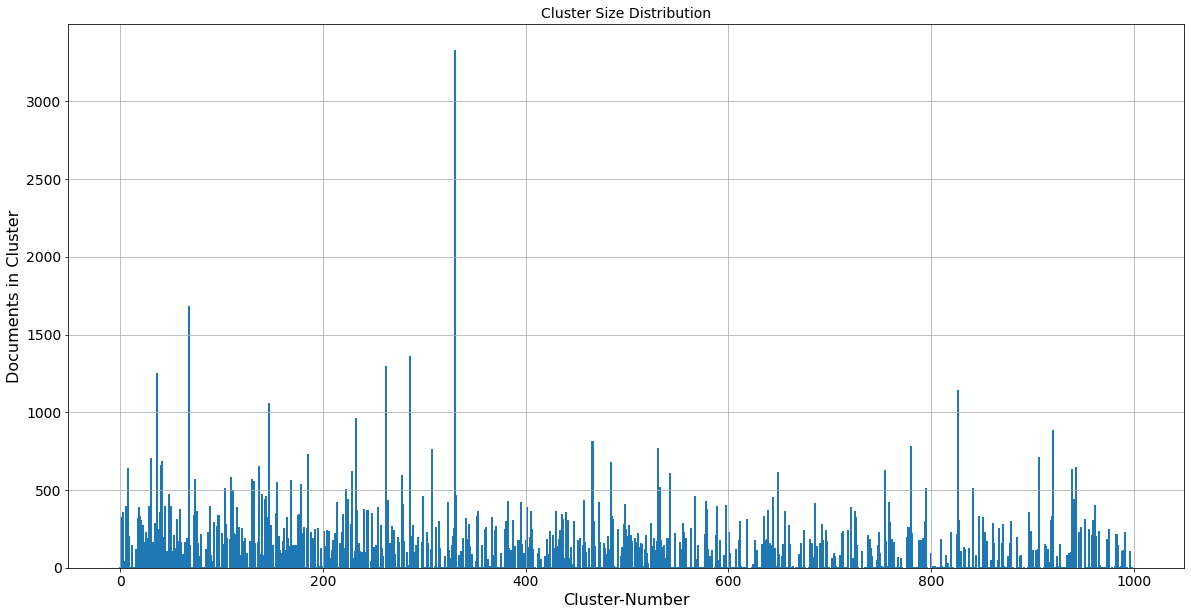


Finished running 'get_pairwise_dist' in 0.0001 mins


Number of Cluster Pairs : 499500

Finished running 'get_cluster_pairs' in 0.0023 mins

499500

Finished running 'cluster2doc' in 0.0004 mins


Finished running 'filter_clusters' in 0.1834 mins

Filtered CLustered Pairs : 55


In [6]:
# Pipeline test
# path = "/data/3/karthik/preference_prediction/articles.csv"

# Pipeline test
path = "../articles.csv"

main_df = load_data(path)

sampled_df = sample_data(df=main_df,sample_size=0.2,seed=RANDOM_SEED)
print("Sampled Size: %s" %str(sampled_df.shape[0]))

sampled_df["processed_text"] = preprocess_texts(text_lists=sampled_df["text"])

vectors,vocab,tfidf_vectorizer = vectorization(df=sampled_df,min_df=50,max_df=0.75,seed=RANDOM_SEED)

reduced_vectors = dimensionality_reduction(vectors=vectors,mode="SVD_LSA",dim=500,seed=RANDOM_SEED)

## to choose k
num_clusters_sett = [500,1000,2000,3000]
f_cp_map = {}

clusters,cluster_clf = run_clustering(vectors=reduced_vectors,seed=RANDOM_SEED,num_clusters=1000,clus_type="kmeans")

# cluster_score = score_cluster(vectors,cluster_clf,score_type="sil_score")

cluster_sizes = get_cluster_sizes(cluster_clf)

plot_size_dist(cluster_sizes)

cluster_pair_dist_mat = get_pairwise_dist(cluster_clf,dist_type="cosine")

cluster_pairs = get_cluster_pairs(num_clusters=1000)
print(len(cluster_pairs))

doc_2_cluster_map = cluster2doc(num_texts=sampled_df.shape[0],cluster_labels=cluster_clf.labels_)

filtered_cluster_pairs = filter_clusters(cluster_pairs=cluster_pairs,
                                        doc_2_cluster_map=doc_2_cluster_map,
                                        cluster_sizes=cluster_sizes,
                                        partisan_scores=sampled_df["binary_ps"].tolist(),
                                        min_size=500,
                                        max_size=5000,
                                        min_partisan_size=0.4)

print("Filtered CLustered Pairs : %s" %str(len(filtered_cluster_pairs)))

In [7]:
top100 = get_top_100_clusterpairs(cluster_pairs=filtered_cluster_pairs,dist_matrix=cluster_pair_dist_mat,reverse=True)


Finished running 'get_top_100_clusterpairs' in 0.0000 mins



## Cluster Similarity vs Model Performance

In [8]:
df_result = run_train_all(X = reduced_vectors,
                          cluster_2_doc_map = doc_2_cluster_map ,
                          df = sampled_df ,
                          cluster_pairs = top100,
                          cosine_mat = cluster_pair_dist_mat,
                          thresholds = [0.5,0.7,0.9],
                          user_type="Heterogeneous")

Training model for cluster pair : 0
Train Label Dist :
 0 : 350
 1:303
Test Label Dist :
 0.0 : 481
 1.0:404

Finished running 'create_train_test' in 0.0001 mins

(885, 2)

Finished running 'run_model' in 0.0077 mins

Training model for cluster pair : 1
Train Label Dist :
 0 : 774
 1:523
Test Label Dist :
 0.0 : 218
 1.0:299

Finished running 'create_train_test' in 0.0002 mins

(517, 2)

Finished running 'run_model' in 0.0207 mins

Training model for cluster pair : 2
Train Label Dist :
 0 : 285
 1:276
Test Label Dist :
 0.0 : 390
 1.0:390

Finished running 'create_train_test' in 0.0002 mins

(780, 2)

Finished running 'run_model' in 0.0083 mins

Training model for cluster pair : 3
Train Label Dist :
 0 : 274
 1:279
Test Label Dist :
 0.0 : 523
 1.0:774

Finished running 'create_train_test' in 0.0002 mins

(1297, 2)

Finished running 'run_model' in 0.0058 mins

Training model for cluster pair : 4
Train Label Dist :
 0 : 285
 1:276
Test Label Dist :
 0.0 : 523
 1.0:774

Finished running 

In [9]:
# for threshold in [0.5,0.7,0.9]:
#     plot_sim_vs_score(df_result,threshold)

In [10]:
df_result_homog = run_train_all(X = reduced_vectors,
                          cluster_2_doc_map = doc_2_cluster_map ,
                          df = sampled_df ,
                          cluster_pairs = top100,
                          cosine_mat = cluster_pair_dist_mat,
                          thresholds = [0.5,0.7,0.9],
                          user_type="Homogeneous")

Training model for cluster pair : 0
Train Label Dist :
 0 : 350
 1:303
Test Label Dist :
 0 : 404
 1:481

Finished running 'create_train_test' in 0.0001 mins

(885, 2)

Finished running 'run_model' in 0.0081 mins

Training model for cluster pair : 1
Train Label Dist :
 0 : 774
 1:523
Test Label Dist :
 0 : 299
 1:218

Finished running 'create_train_test' in 0.0001 mins

(517, 2)

Finished running 'run_model' in 0.0202 mins

Training model for cluster pair : 2
Train Label Dist :
 0 : 285
 1:276
Test Label Dist :
 0 : 390
 1:390

Finished running 'create_train_test' in 0.0001 mins

(780, 2)

Finished running 'run_model' in 0.0085 mins

Training model for cluster pair : 3
Train Label Dist :
 0 : 274
 1:279
Test Label Dist :
 0 : 774
 1:523

Finished running 'create_train_test' in 0.0001 mins

(1297, 2)

Finished running 'run_model' in 0.0064 mins

Training model for cluster pair : 4
Train Label Dist :
 0 : 285
 1:276
Test Label Dist :
 0 : 774
 1:523

Finished running 'create_train_test' 

In [11]:
# for threshold in [0.5,0.7,0.9]:
#     plot_sim_vs_score(df_result_homog,threshold)

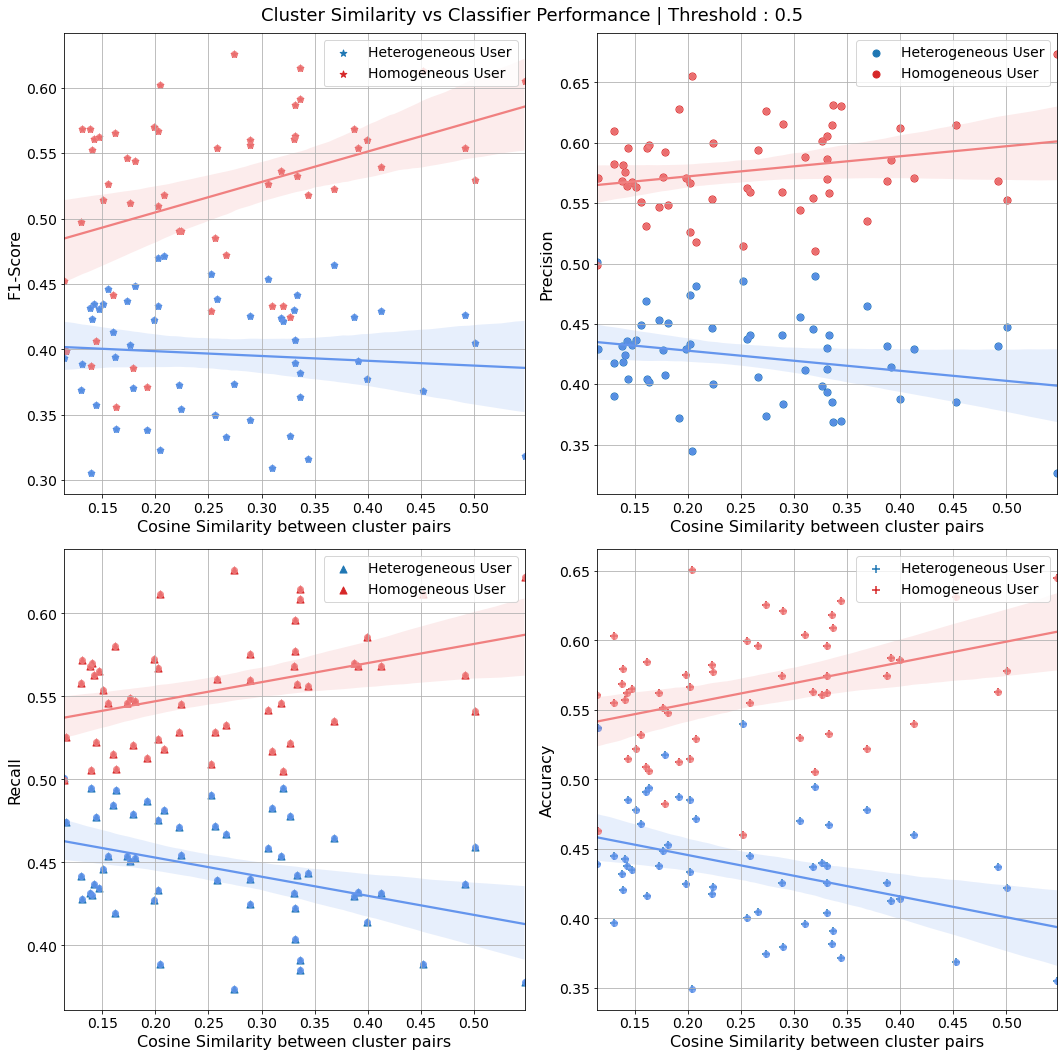


Finished running 'plot_sim_vs_score_all_users' in 0.0202 mins



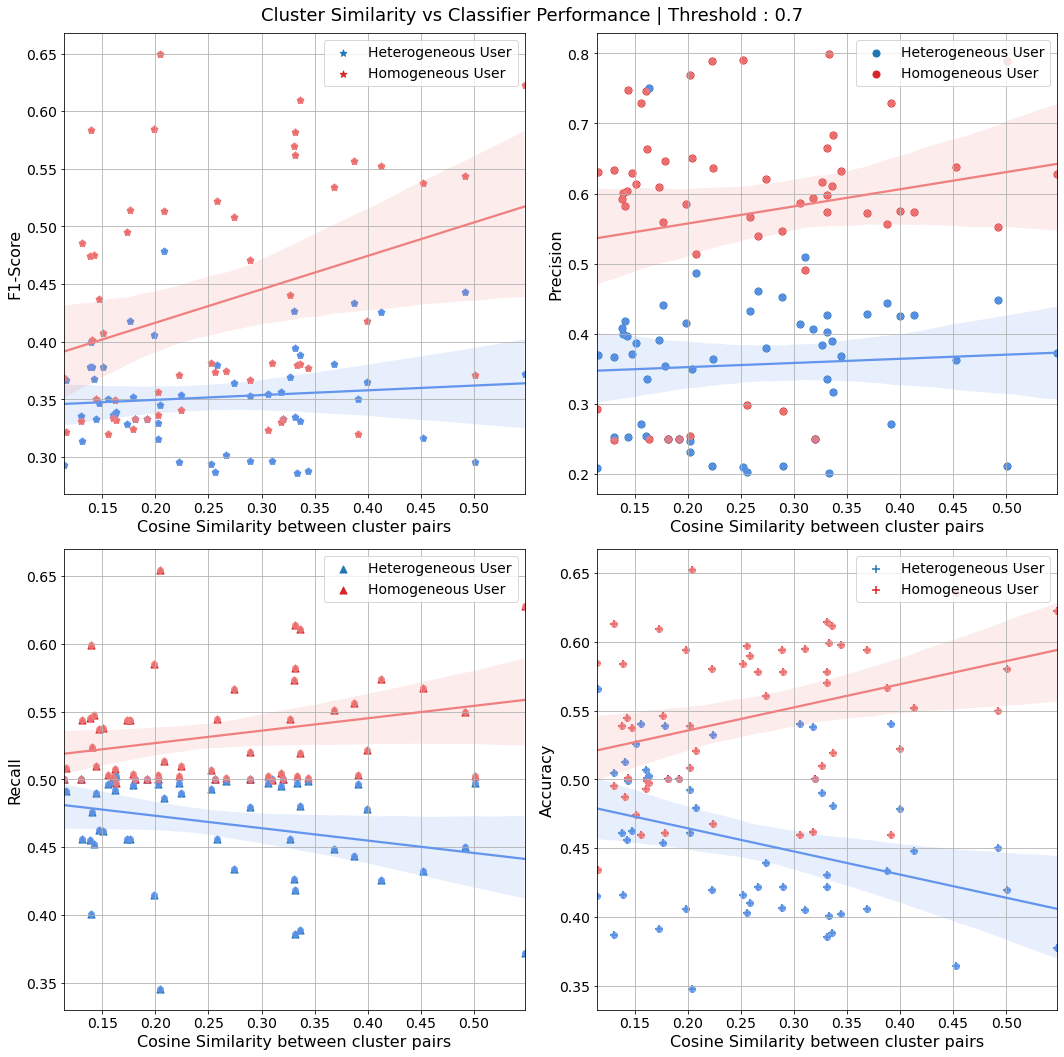


Finished running 'plot_sim_vs_score_all_users' in 0.0192 mins



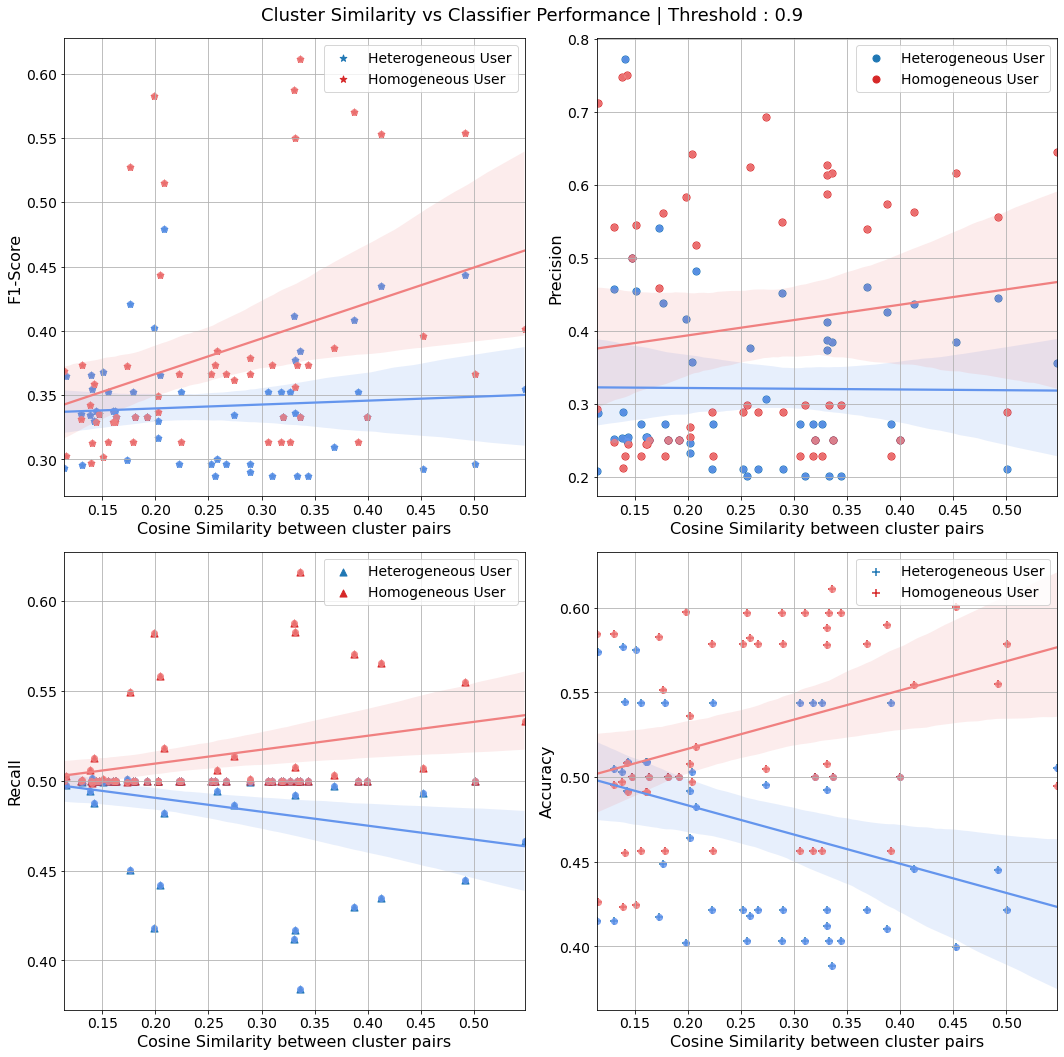


Finished running 'plot_sim_vs_score_all_users' in 0.0187 mins



In [12]:
for threshold in [0.5,0.7,0.9]:
    plot_sim_vs_score_all_users(df_results_hetero=df_result,
                                df_results_homo=df_result_homog,
                                threshold=threshold)

## Online Learning Setting - Active Learning Setting (Performance Measured on Held Out Validation Dataset)

In [13]:
hetero_scores = run_online_setting_active(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                   user_type="Heterogeneous")

Training model for cluster pair : 0
Train Label Dist :
 0 : 350
 1:303
Test Label Dist :
 0.0 : 481
 1.0:404

Finished running 'create_train_test' in 0.0001 mins

Cluster 2: Data Distribution (Candidate Pool and Validation Set) 
Candidate Pool Label Dist :
 0.0 : 54
 1.0:46
Validation Label Dist :
 0.0 : 427
 1.0:358
Training model for cluster pair : 1
Train Label Dist :
 0 : 774
 1:523
Test Label Dist :
 0.0 : 218
 1.0:299

Finished running 'create_train_test' in 0.0002 mins

Cluster 2: Data Distribution (Candidate Pool and Validation Set) 
Candidate Pool Label Dist :
 0.0 : 42
 1.0:58
Validation Label Dist :
 0.0 : 176
 1.0:241
Training model for cluster pair : 2
Train Label Dist :
 0 : 285
 1:276
Test Label Dist :
 0.0 : 390
 1.0:390

Finished running 'create_train_test' in 0.0002 mins

Cluster 2: Data Distribution (Candidate Pool and Validation Set) 
Candidate Pool Label Dist :
 0.0 : 50
 1.0:50
Validation Label Dist :
 0.0 : 340
 1.0:340
Training model for cluster pair : 3
Train L

In [14]:
homo_scores =  run_online_setting_active(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                   user_type="Homogeneous")

Training model for cluster pair : 0
Train Label Dist :
 0 : 350
 1:303
Test Label Dist :
 0 : 404
 1:481

Finished running 'create_train_test' in 0.0001 mins

Cluster 2: Data Distribution (Candidate Pool and Validation Set) 
Candidate Pool Label Dist :
 0 : 46
 1:54
Validation Label Dist :
 0 : 358
 1:427
Training model for cluster pair : 1
Train Label Dist :
 0 : 774
 1:523
Test Label Dist :
 0 : 299
 1:218

Finished running 'create_train_test' in 0.0001 mins

Cluster 2: Data Distribution (Candidate Pool and Validation Set) 
Candidate Pool Label Dist :
 0 : 58
 1:42
Validation Label Dist :
 0 : 241
 1:176
Training model for cluster pair : 2
Train Label Dist :
 0 : 285
 1:276
Test Label Dist :
 0 : 390
 1:390

Finished running 'create_train_test' in 0.0001 mins

Cluster 2: Data Distribution (Candidate Pool and Validation Set) 
Candidate Pool Label Dist :
 0 : 50
 1:50
Validation Label Dist :
 0 : 340
 1:340
Training model for cluster pair : 3
Train Label Dist :
 0 : 274
 1:279
Test Lab

In [15]:
hetero_scores.keys()

dict_keys([(137, 920), (262, 533), (132, 780), (155, 262), (132, 262), (262, 780), (533, 920), (132, 533), (137, 533), (185, 262), (223, 780), (132, 920), (223, 262), (132, 223), (137, 780), (132, 137), (223, 920), (533, 780), (780, 920), (178, 262), (262, 920), (103, 533), (137, 262), (137, 223), (178, 533), (155, 533), (103, 262), (223, 533), (103, 920), (185, 533), (132, 185), (155, 185), (103, 137), (103, 132), (132, 178), (185, 780), (103, 780), (178, 920), (132, 155), (137, 178), (178, 780), (103, 223), (185, 223), (185, 920), (137, 185), (155, 780), (178, 223), (137, 155), (155, 920), (103, 185), (155, 223), (155, 178), (103, 155), (178, 185), (103, 178)])

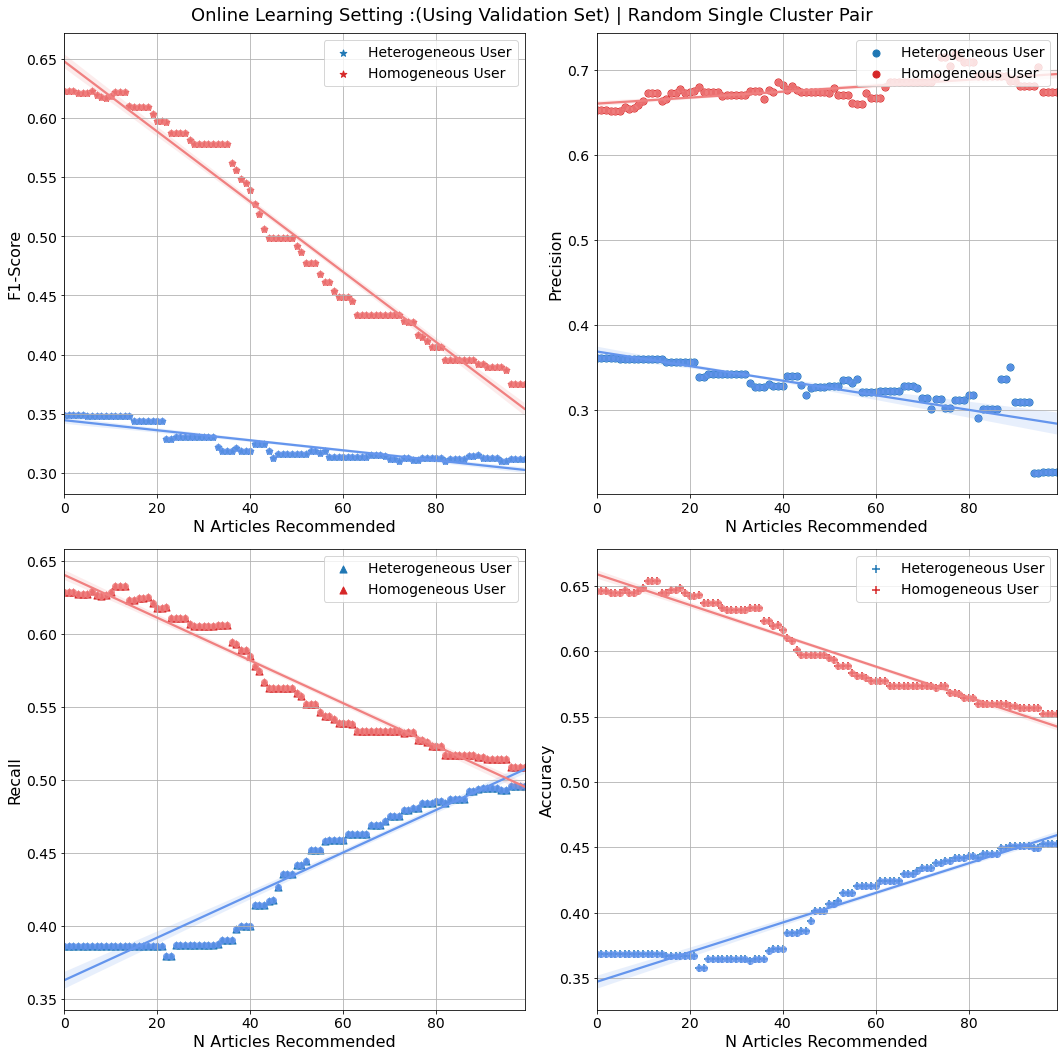


Finished running 'plot_online_setting_per_clusterpair' in 0.0191 mins



In [16]:
plot_online_setting_per_clusterpair(homo_scores[(137,920)],hetero_scores[(137,920)])

In [17]:
# plot_online_setting_per_clusterpair(homo_scores[(533, 780)],hetero_scores[(533, 780)])


Finished running 'combine_scores_cumu_online_setting' in 0.0001 mins


Finished running 'combine_scores_cumu_online_setting' in 0.0000 mins



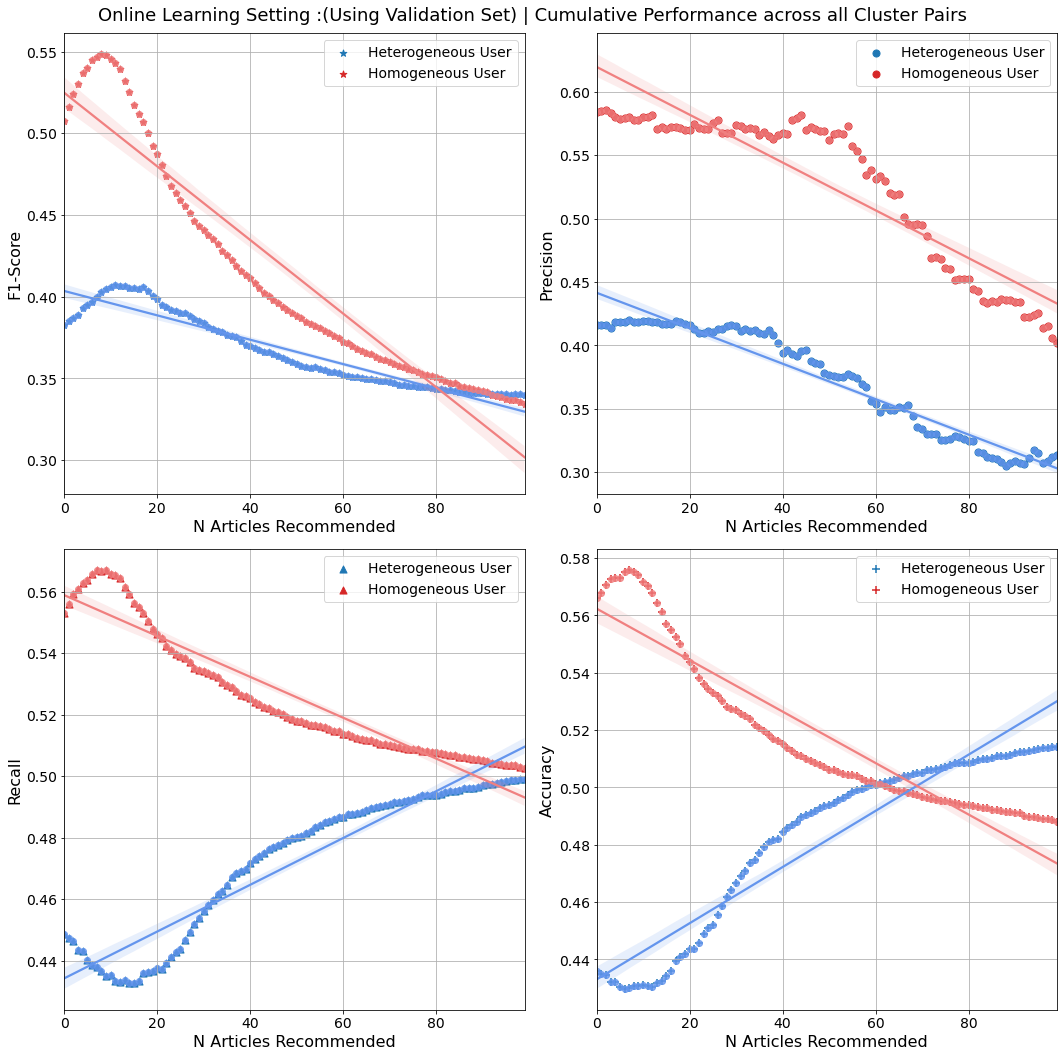


Finished running 'plot_online_setting_per_clusterpair' in 0.0185 mins


Finished running 'plot_online_learning_cumulative' in 0.0186 mins



In [18]:
plot_online_learning_cumulative(homo_scores,hetero_scores)

## Online Learning Setting - Information Retrieval Setting (Performance Metrics measured @Kth interaction)

In [19]:
hetero_scores = run_online_setting_atK(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                   user_type="Heterogeneous")

Training model for cluster pair : 0
Train Label Dist :
 0 : 350
 1:303
Test Label Dist :
 0.0 : 481
 1.0:404

Finished running 'create_train_test' in 0.0001 mins

Total Rel Docs : 404
Training model for cluster pair : 1
Train Label Dist :
 0 : 774
 1:523
Test Label Dist :
 0.0 : 218
 1.0:299

Finished running 'create_train_test' in 0.0002 mins

Total Rel Docs : 299
Training model for cluster pair : 2
Train Label Dist :
 0 : 285
 1:276
Test Label Dist :
 0.0 : 390
 1.0:390

Finished running 'create_train_test' in 0.0001 mins

Total Rel Docs : 390
Training model for cluster pair : 3
Train Label Dist :
 0 : 274
 1:279
Test Label Dist :
 0.0 : 523
 1.0:774

Finished running 'create_train_test' in 0.0002 mins

Total Rel Docs : 774
Training model for cluster pair : 4
Train Label Dist :
 0 : 285
 1:276
Test Label Dist :
 0.0 : 523
 1.0:774

Finished running 'create_train_test' in 0.0002 mins

Total Rel Docs : 774
Training model for cluster pair : 5
Train Label Dist :
 0 : 774
 1:523
Test Labe

In [20]:
homo_scores =  run_online_setting_atK(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                   user_type="Homogeneous")

Training model for cluster pair : 0
Train Label Dist :
 0 : 350
 1:303
Test Label Dist :
 0 : 404
 1:481

Finished running 'create_train_test' in 0.0001 mins

Total Rel Docs : 481
Training model for cluster pair : 1
Train Label Dist :
 0 : 774
 1:523
Test Label Dist :
 0 : 299
 1:218

Finished running 'create_train_test' in 0.0001 mins

Total Rel Docs : 218
Training model for cluster pair : 2
Train Label Dist :
 0 : 285
 1:276
Test Label Dist :
 0 : 390
 1:390

Finished running 'create_train_test' in 0.0001 mins

Total Rel Docs : 390
Training model for cluster pair : 3
Train Label Dist :
 0 : 274
 1:279
Test Label Dist :
 0 : 774
 1:523

Finished running 'create_train_test' in 0.0001 mins

Total Rel Docs : 523
Training model for cluster pair : 4
Train Label Dist :
 0 : 285
 1:276
Test Label Dist :
 0 : 774
 1:523

Finished running 'create_train_test' in 0.0001 mins

Total Rel Docs : 523
Training model for cluster pair : 5
Train Label Dist :
 0 : 774
 1:523
Test Label Dist :
 0 : 390
 1

In [21]:
hetero_scores.keys()

dict_keys([(137, 920), (262, 533), (132, 780), (155, 262), (132, 262), (262, 780), (533, 920), (132, 533), (137, 533), (185, 262), (223, 780), (132, 920), (223, 262), (132, 223), (137, 780), (132, 137), (223, 920), (533, 780), (780, 920), (178, 262), (262, 920), (103, 533), (137, 262), (137, 223), (178, 533), (155, 533), (103, 262), (223, 533), (103, 920), (185, 533), (132, 185), (155, 185), (103, 137), (103, 132), (132, 178), (185, 780), (103, 780), (178, 920), (132, 155), (137, 178), (178, 780), (103, 223), (185, 223), (185, 920), (137, 185), (155, 780), (178, 223), (137, 155), (155, 920), (103, 185), (155, 223), (155, 178), (103, 155), (178, 185), (103, 178)])

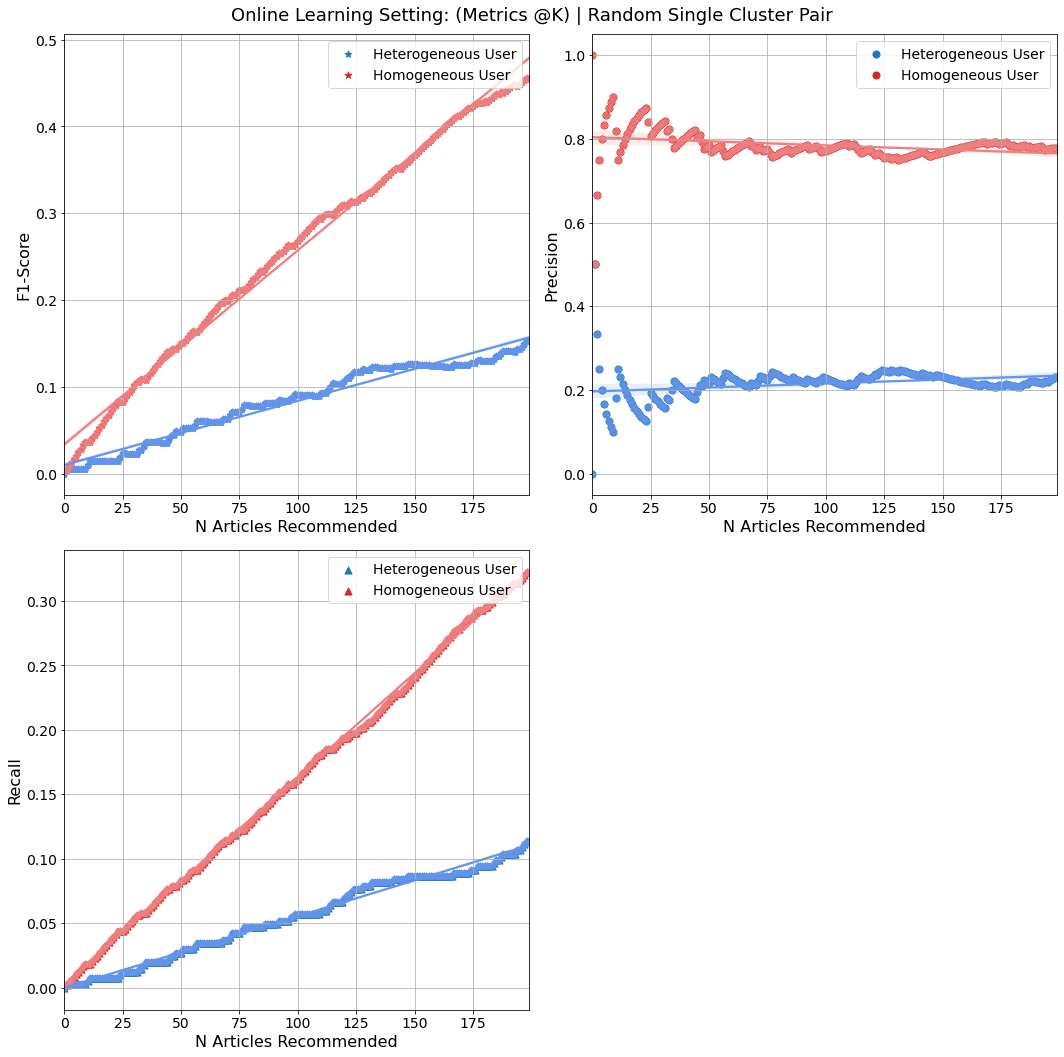


Finished running 'plot_online_setting_per_clusterpair' in 0.0164 mins



In [22]:
plot_online_setting_per_clusterpair(homo_scores[(137,920)],hetero_scores[(137,920)],single=True,active=False)

In [23]:
# plot_online_setting_per_clusterpair(homo_scores[(533, 780)],hetero_scores[(533, 780)],single=True,active=False)


Finished running 'combine_scores_cumu_online_setting' in 0.0000 mins


Finished running 'combine_scores_cumu_online_setting' in 0.0000 mins



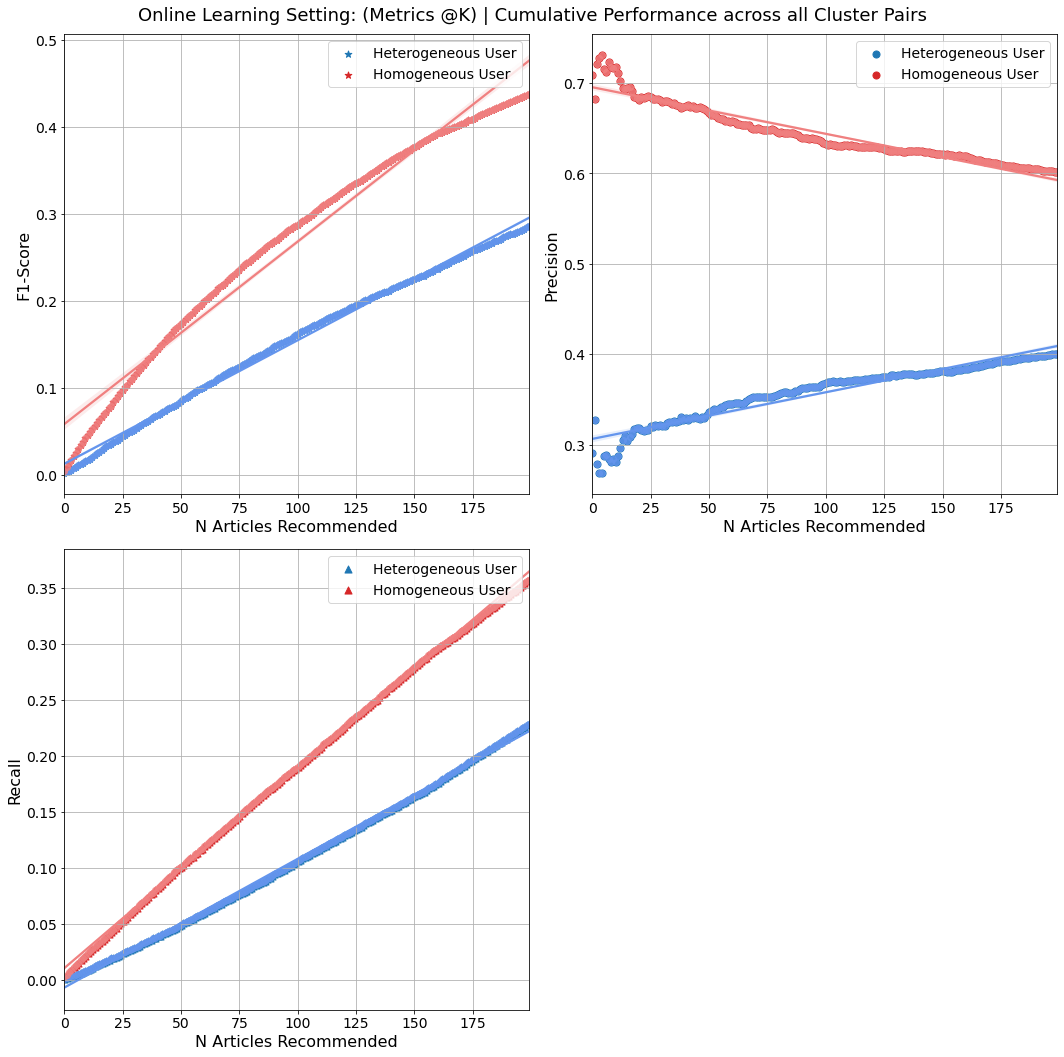


Finished running 'plot_online_setting_per_clusterpair' in 0.0173 mins


Finished running 'plot_online_learning_cumulative' in 0.0173 mins



In [24]:
plot_online_learning_cumulative(homo_scores,hetero_scores,active=False)

## Single Cluster Performance : To detect how hard the task of identifying change in topic

In [25]:
hetero_scores = run_single_cluster_performance(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                   user_type="Heterogeneous")

Training model for cluster pair : 0
Train Label Dist :
 0 : 350
 1:303
Test Label Dist :
 0.0 : 481
 1.0:404

Finished running 'create_train_test' in 0.0001 mins

Total Rel Docs : 91
Training model for cluster pair : 1
Train Label Dist :
 0 : 774
 1:523
Test Label Dist :
 0.0 : 218
 1.0:299

Finished running 'create_train_test' in 0.0002 mins

Total Rel Docs : 116
Training model for cluster pair : 2
Train Label Dist :
 0 : 285
 1:276
Test Label Dist :
 0.0 : 390
 1.0:390

Finished running 'create_train_test' in 0.0001 mins

Total Rel Docs : 100
Training model for cluster pair : 3
Train Label Dist :
 0 : 274
 1:279
Test Label Dist :
 0.0 : 523
 1.0:774

Finished running 'create_train_test' in 0.0002 mins

Total Rel Docs : 119
Training model for cluster pair : 4
Train Label Dist :
 0 : 285
 1:276
Test Label Dist :
 0.0 : 523
 1.0:774

Finished running 'create_train_test' in 0.0002 mins

Total Rel Docs : 119
Training model for cluster pair : 5
Train Label Dist :
 0 : 774
 1:523
Test Label

In [26]:
homo_scores =  run_single_cluster_performance(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                   user_type="Homogeneous")

Training model for cluster pair : 0
Train Label Dist :
 0 : 350
 1:303
Test Label Dist :
 0 : 404
 1:481

Finished running 'create_train_test' in 0.0001 mins

Total Rel Docs : 109
Training model for cluster pair : 1
Train Label Dist :
 0 : 774
 1:523
Test Label Dist :
 0 : 299
 1:218

Finished running 'create_train_test' in 0.0001 mins

Total Rel Docs : 84
Training model for cluster pair : 2
Train Label Dist :
 0 : 285
 1:276
Test Label Dist :
 0 : 390
 1:390

Finished running 'create_train_test' in 0.0001 mins

Total Rel Docs : 100
Training model for cluster pair : 3
Train Label Dist :
 0 : 274
 1:279
Test Label Dist :
 0 : 774
 1:523

Finished running 'create_train_test' in 0.0001 mins

Total Rel Docs : 81
Training model for cluster pair : 4
Train Label Dist :
 0 : 285
 1:276
Test Label Dist :
 0 : 774
 1:523

Finished running 'create_train_test' in 0.0001 mins

Total Rel Docs : 81
Training model for cluster pair : 5
Train Label Dist :
 0 : 774
 1:523
Test Label Dist :
 0 : 390
 1:39

In [27]:
hetero_scores.keys()

dict_keys([(137, 920), (262, 533), (132, 780), (155, 262), (132, 262), (262, 780), (533, 920), (132, 533), (137, 533), (185, 262), (223, 780), (132, 920), (223, 262), (132, 223), (137, 780), (132, 137), (223, 920), (533, 780), (780, 920), (178, 262), (262, 920), (103, 533), (137, 262), (137, 223), (178, 533), (155, 533), (103, 262), (223, 533), (103, 920), (185, 533), (132, 185), (155, 185), (103, 137), (103, 132), (132, 178), (185, 780), (103, 780), (178, 920), (132, 155), (137, 178), (178, 780), (103, 223), (185, 223), (185, 920), (137, 185), (155, 780), (178, 223), (137, 155), (155, 920), (103, 185), (155, 223), (155, 178), (103, 155), (178, 185), (103, 178)])

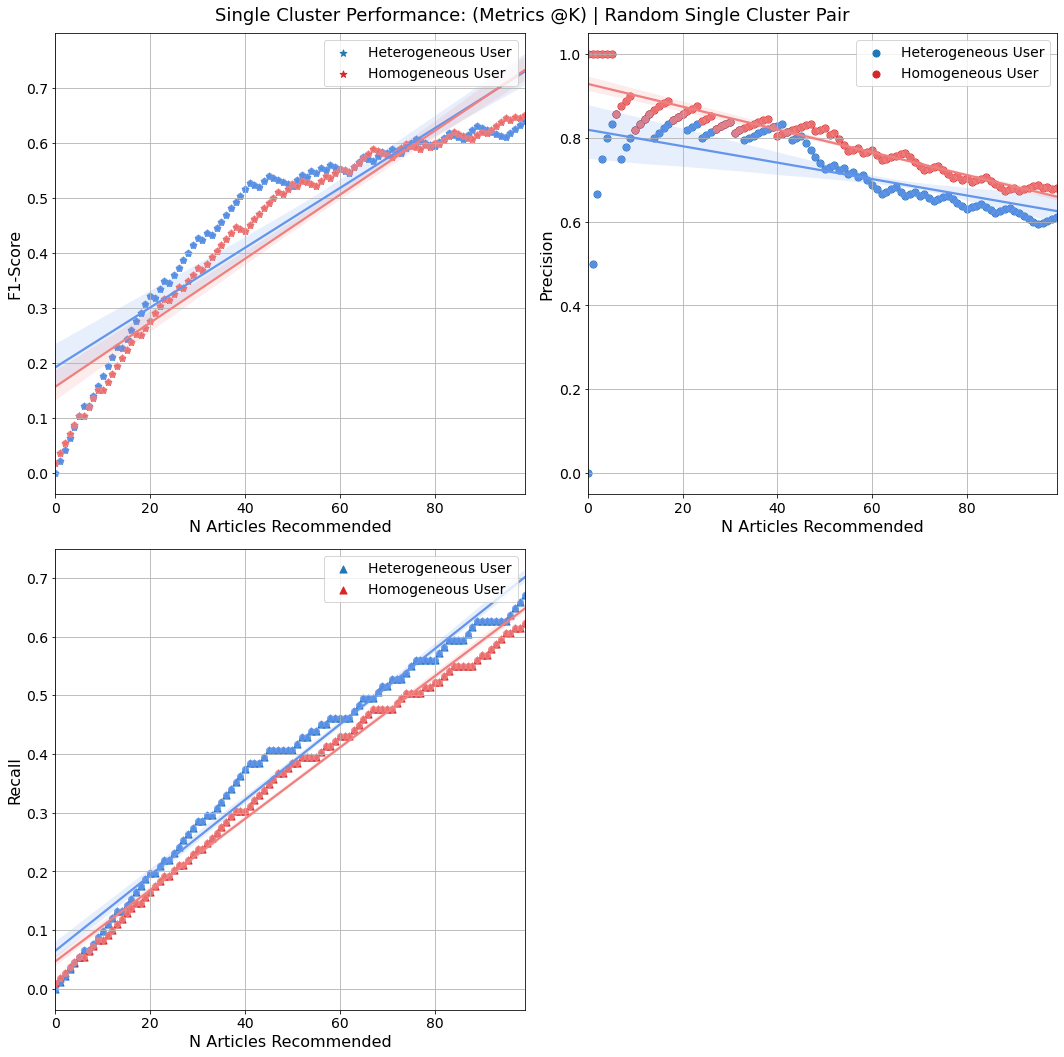


Finished running 'plot_single_cluster_performance' in 0.0154 mins



In [28]:
plot_single_cluster_performance(homo_scores[(137,920)],hetero_scores[(137,920)],single=True)


Finished running 'combine_scores_cumu_online_setting' in 0.0000 mins


Finished running 'combine_scores_cumu_online_setting' in 0.0000 mins



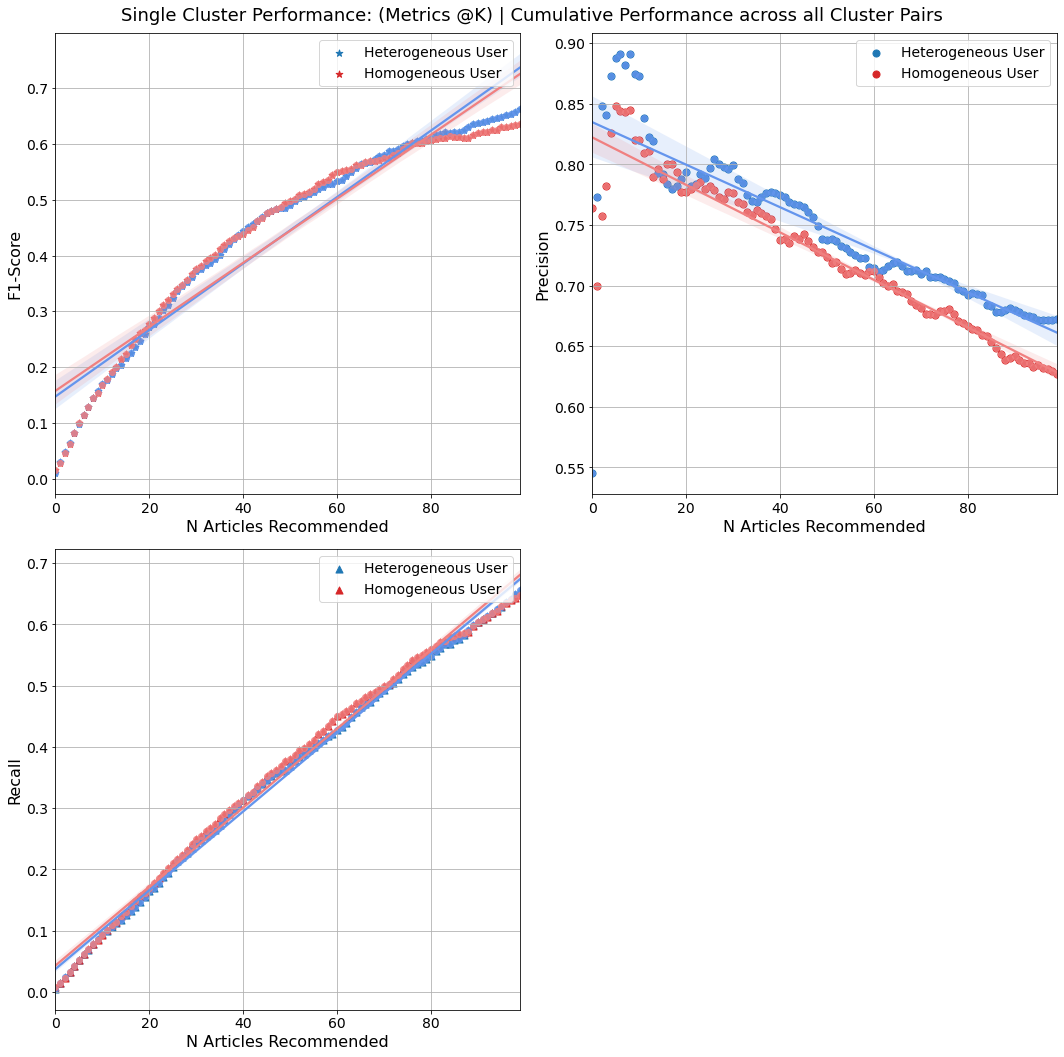


Finished running 'plot_single_cluster_performance' in 0.0152 mins


Finished running 'plot_single_cluster_cumulative' in 0.0152 mins



In [29]:
plot_single_cluster_cumulative(homo_scores,hetero_scores)

## Regularization vs Performance@K

In [65]:
hetero_scores = run_regularization_variation(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Heterogeneous",
                                 reg_constants=[0.0001,0.001,0.01,0.1,1.0])

Training model for cluster pair : 0
Train Label Dist :
 0 : 350
 1:303
Test Label Dist :
 0.0 : 481
 1.0:404

Finished running 'create_train_test' in 0.0001 mins

Total Rel Docs : 404
Total Rel Docs : 385
Total Rel Docs : 357
Total Rel Docs : 313
Total Rel Docs : 272
Training model for cluster pair : 1
Train Label Dist :
 0 : 774
 1:523
Test Label Dist :
 0.0 : 218
 1.0:299

Finished running 'create_train_test' in 0.0002 mins

Total Rel Docs : 299
Total Rel Docs : 249
Total Rel Docs : 201
Total Rel Docs : 141
Total Rel Docs : 82
Training model for cluster pair : 2
Train Label Dist :
 0 : 285
 1:276
Test Label Dist :
 0.0 : 390
 1.0:390

Finished running 'create_train_test' in 0.0001 mins

Total Rel Docs : 390
Total Rel Docs : 366
Total Rel Docs : 327
Total Rel Docs : 276
Total Rel Docs : 232
Training model for cluster pair : 3
Train Label Dist :
 0 : 274
 1:279
Test Label Dist :
 0.0 : 523
 1.0:774

Finished running 'create_train_test' in 0.0002 mins

Total Rel Docs : 774
Total Rel Doc

In [66]:
homo_scores = run_regularization_variation(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Homogeneous",
                                 reg_constants=[0.0001,0.001,0.01,0.1,1.0])

Training model for cluster pair : 0
Train Label Dist :
 0 : 350
 1:303
Test Label Dist :
 0 : 404
 1:481

Finished running 'create_train_test' in 0.0001 mins

Total Rel Docs : 481
Total Rel Docs : 400
Total Rel Docs : 328
Total Rel Docs : 271
Total Rel Docs : 213
Training model for cluster pair : 1
Train Label Dist :
 0 : 774
 1:523
Test Label Dist :
 0 : 299
 1:218

Finished running 'create_train_test' in 0.0001 mins

Total Rel Docs : 218
Total Rel Docs : 169
Total Rel Docs : 116
Total Rel Docs : 78
Total Rel Docs : 36
Training model for cluster pair : 2
Train Label Dist :
 0 : 285
 1:276
Test Label Dist :
 0 : 390
 1:390

Finished running 'create_train_test' in 0.0001 mins

Total Rel Docs : 390
Total Rel Docs : 314
Total Rel Docs : 254
Total Rel Docs : 204
Total Rel Docs : 146
Training model for cluster pair : 3
Train Label Dist :
 0 : 274
 1:279
Test Label Dist :
 0 : 774
 1:523

Finished running 'create_train_test' in 0.0001 mins

Total Rel Docs : 523
Total Rel Docs : 461
Total Rel

In [67]:
homo_scores.keys()

dict_keys([(137, 920), (262, 533), (132, 780), (155, 262), (132, 262), (262, 780), (533, 920), (132, 533), (137, 533), (185, 262), (223, 780), (132, 920), (223, 262), (132, 223), (137, 780), (132, 137), (223, 920), (533, 780), (780, 920), (178, 262), (262, 920), (103, 533), (137, 262), (137, 223), (178, 533), (155, 533), (103, 262), (223, 533), (103, 920), (185, 533), (132, 185), (155, 185), (103, 137), (103, 132), (132, 178), (185, 780), (103, 780), (178, 920), (132, 155), (137, 178), (178, 780), (103, 223), (185, 223), (185, 920), (137, 185), (155, 780), (178, 223), (137, 155), (155, 920), (103, 185), (155, 223), (155, 178), (103, 155), (178, 185), (103, 178)])

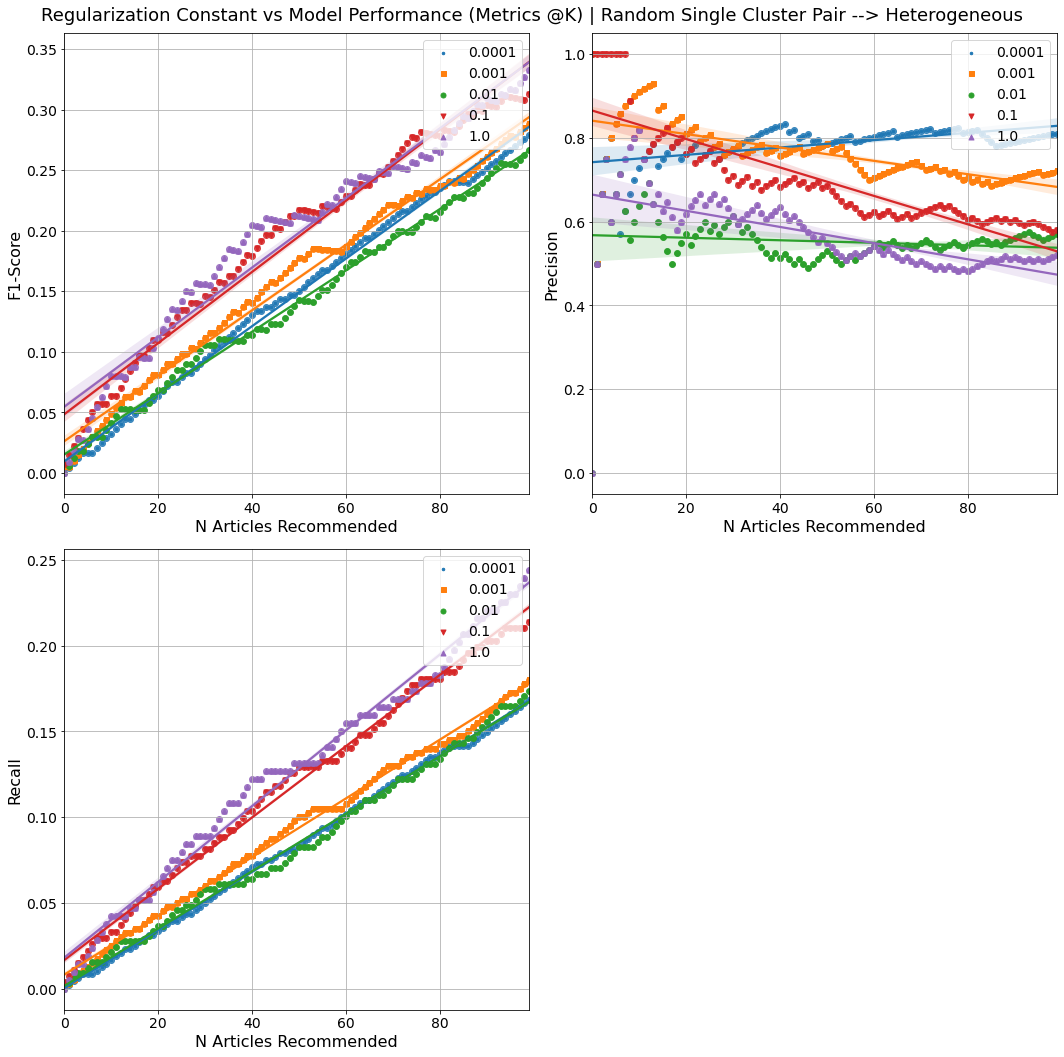


Finished running 'plot_regularization_vs_metrics_at_k' in 0.0307 mins



In [80]:
plot_regularization_vs_metrics_at_k(homo_scores[(137,920)],regularization_constants=[0.0001,0.001,0.01,0.1,1.0],single=True)

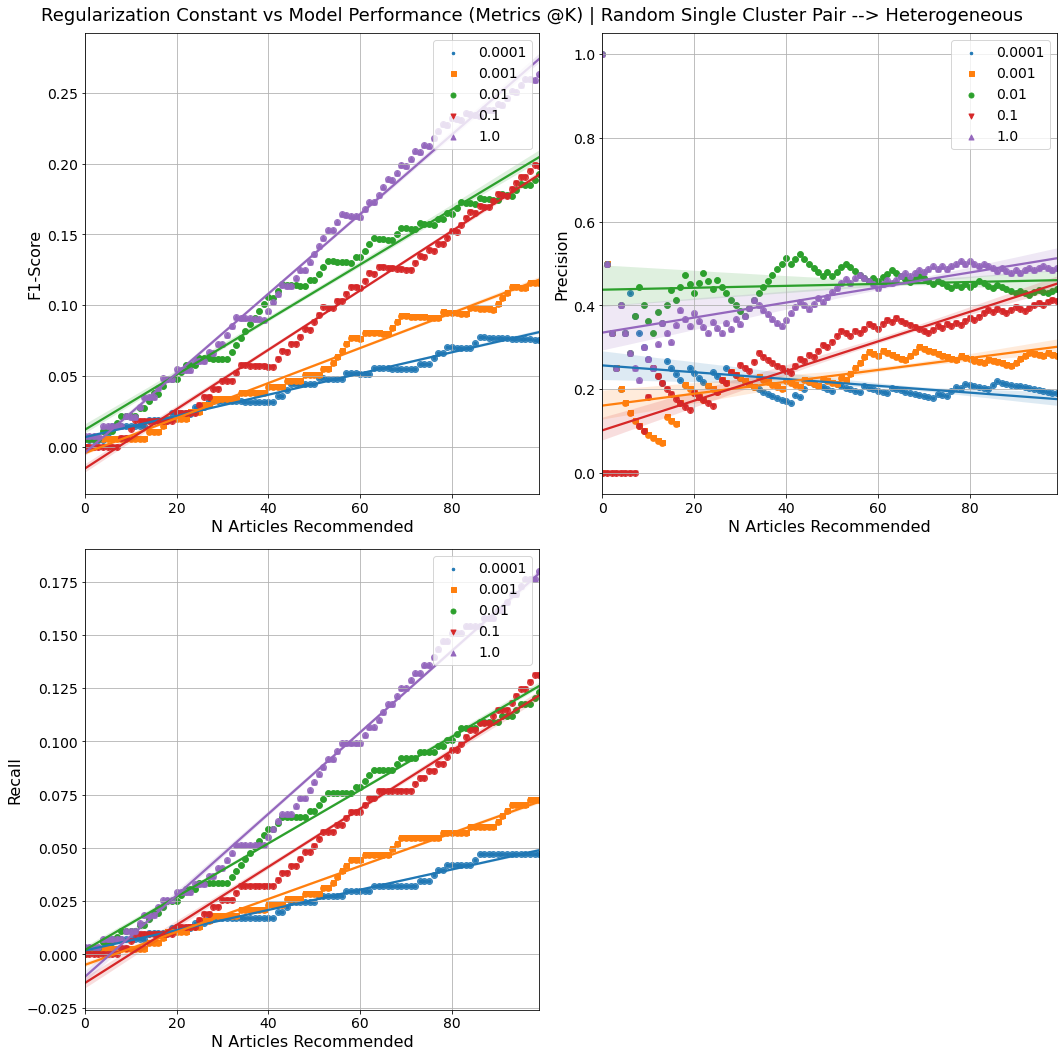


Finished running 'plot_regularization_vs_metrics_at_k' in 0.0289 mins



In [81]:
plot_regularization_vs_metrics_at_k(hetero_scores[(137,920)],regularization_constants=[0.0001,0.001,0.01,0.1,1.0],single=True)


Finished running 'combine_scores_reg_vs_metrics_at_k' in 0.0001 mins



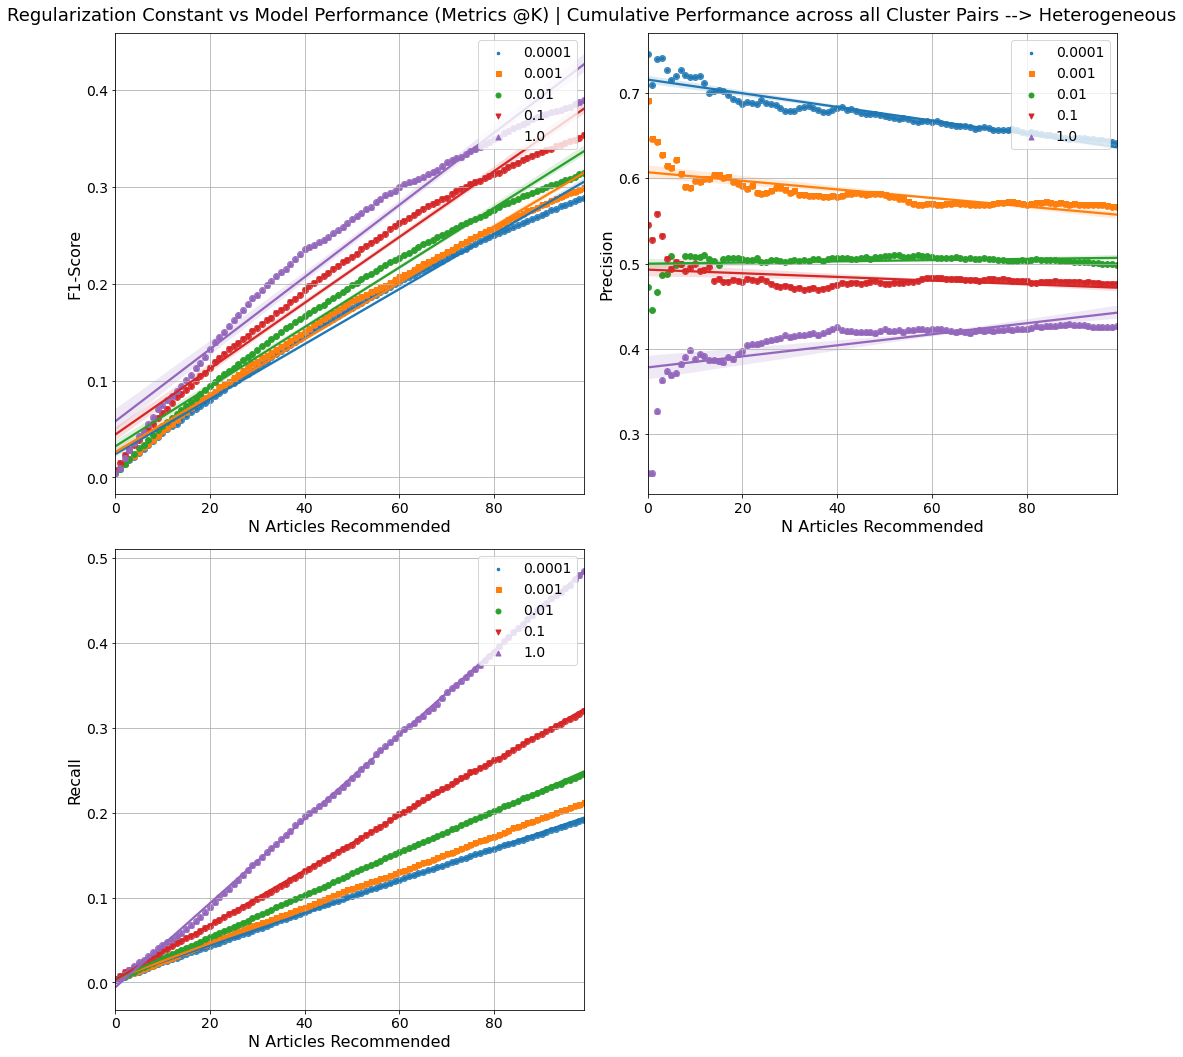


Finished running 'plot_regularization_vs_metrics_at_k' in 0.0278 mins


Finished running 'plot_regularization_vs_metrics_at_k_cumu' in 0.0279 mins



In [82]:
plot_regularization_vs_metrics_at_k_cumu(homo_scores,regularization_constants=[0.0001,0.001,0.01,0.1,1.0])


Finished running 'combine_scores_reg_vs_metrics_at_k' in 0.0001 mins



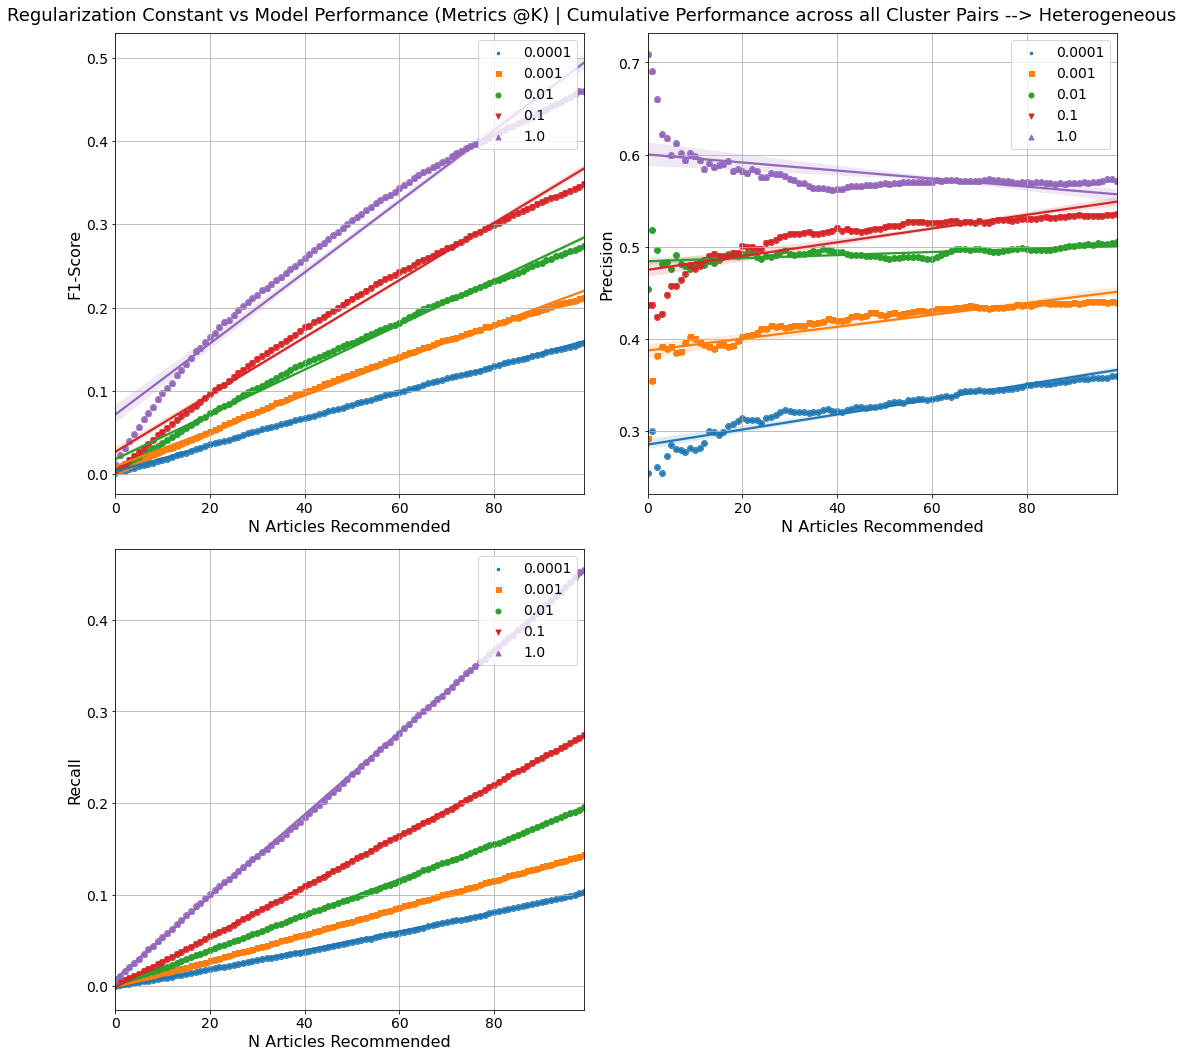


Finished running 'plot_regularization_vs_metrics_at_k' in 0.0279 mins


Finished running 'plot_regularization_vs_metrics_at_k_cumu' in 0.0280 mins



In [83]:
plot_regularization_vs_metrics_at_k_cumu(hetero_scores,regularization_constants=[0.0001,0.001,0.01,0.1,1.0])